# video 처럼 다루어 보자

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset, he_init_weights
from models.video_classifier import VideoClassifier
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 테스트지역 선별

In [3]:
# 테스트 필터 정의
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

### 데이터 전처리 방법 설정

In [4]:
class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 3, 3).permute(1, 0, 2, 3)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

## B, G, R, NIR 사용

In [6]:
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소
bands = 4 #밴드 수

transform = get_transform(bands, scale_channels)

train_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file ="../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.27it/s]



Epoch [1/100], Train Loss: 0.7339, Train Accuracy: 71.77%, Val Loss: 0.6537, Val Accuracy: 78.38%



Epoch 2/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.42it/s]



Epoch [2/100], Train Loss: 0.4824, Train Accuracy: 82.14%, Val Loss: 0.5812, Val Accuracy: 80.10%



Epoch 3/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.46it/s]



Epoch [3/100], Train Loss: 0.4157, Train Accuracy: 84.81%, Val Loss: 0.5340, Val Accuracy: 82.04%



Epoch 4/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 44.85it/s]



Epoch [4/100], Train Loss: 0.3685, Train Accuracy: 86.73%, Val Loss: 0.5885, Val Accuracy: 79.86%



Epoch 5/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 44.81it/s]



Epoch [5/100], Train Loss: 0.3351, Train Accuracy: 87.94%, Val Loss: 0.5451, Val Accuracy: 81.97%



Epoch 6/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.31it/s]



Epoch [6/100], Train Loss: 0.3104, Train Accuracy: 88.86%, Val Loss: 0.4705, Val Accuracy: 84.55%



Epoch 7/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.75it/s]



Epoch [7/100], Train Loss: 0.2946, Train Accuracy: 89.51%, Val Loss: 0.5439, Val Accuracy: 82.11%



Epoch 8/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.61it/s]



Epoch [8/100], Train Loss: 0.2799, Train Accuracy: 90.06%, Val Loss: 0.4760, Val Accuracy: 84.36%



Epoch 9/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.44it/s]



Epoch [9/100], Train Loss: 0.2681, Train Accuracy: 90.49%, Val Loss: 0.4742, Val Accuracy: 83.62%



Epoch 10/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.42it/s]



Epoch [10/100], Train Loss: 0.2577, Train Accuracy: 90.79%, Val Loss: 0.5003, Val Accuracy: 83.75%



Epoch 11/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.59it/s]



Epoch [11/100], Train Loss: 0.2501, Train Accuracy: 91.17%, Val Loss: 0.5659, Val Accuracy: 82.27%



Epoch 12/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.46it/s]



Epoch [12/100], Train Loss: 0.2415, Train Accuracy: 91.35%, Val Loss: 0.5393, Val Accuracy: 83.48%



Epoch 13/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.04it/s]



Epoch [13/100], Train Loss: 0.2328, Train Accuracy: 91.71%, Val Loss: 0.5055, Val Accuracy: 83.83%



Epoch 14/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.52it/s]



Epoch [14/100], Train Loss: 0.2296, Train Accuracy: 91.79%, Val Loss: 0.5475, Val Accuracy: 83.02%



Epoch 15/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.36it/s]



Epoch [15/100], Train Loss: 0.2225, Train Accuracy: 92.05%, Val Loss: 0.5361, Val Accuracy: 82.71%



Epoch 16/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.04it/s]



Epoch [16/100], Train Loss: 0.2152, Train Accuracy: 92.32%, Val Loss: 0.4842, Val Accuracy: 84.60%



Epoch 17/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.50it/s]



Epoch [17/100], Train Loss: 0.2110, Train Accuracy: 92.46%, Val Loss: 0.5385, Val Accuracy: 83.78%



Epoch 18/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.20it/s]



Epoch [18/100], Train Loss: 0.2059, Train Accuracy: 92.64%, Val Loss: 0.5247, Val Accuracy: 84.18%



Epoch 19/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.51it/s]



Epoch [19/100], Train Loss: 0.2024, Train Accuracy: 92.68%, Val Loss: 0.6174, Val Accuracy: 82.36%



Epoch 20/100 - Validation: 100%|██████████| 1163/1163 [00:24<00:00, 47.58it/s]



Epoch [20/100], Train Loss: 0.1976, Train Accuracy: 92.96%, Val Loss: 0.4867, Val Accuracy: 85.41%



Epoch 21/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 44.77it/s]



Epoch [21/100], Train Loss: 0.1929, Train Accuracy: 93.14%, Val Loss: 0.4954, Val Accuracy: 85.68%



Epoch 22/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.28it/s]



Epoch [22/100], Train Loss: 0.1889, Train Accuracy: 93.20%, Val Loss: 0.6486, Val Accuracy: 82.67%



Epoch 23/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.26it/s]



Epoch [23/100], Train Loss: 0.1854, Train Accuracy: 93.28%, Val Loss: 0.5280, Val Accuracy: 84.23%



Epoch 24/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.48it/s]



Epoch [24/100], Train Loss: 0.1817, Train Accuracy: 93.54%, Val Loss: 0.5904, Val Accuracy: 83.63%



Epoch 25/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.29it/s]



Epoch [25/100], Train Loss: 0.1782, Train Accuracy: 93.56%, Val Loss: 0.5818, Val Accuracy: 84.43%



Epoch 26/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.01it/s]



Epoch [26/100], Train Loss: 0.1745, Train Accuracy: 93.70%, Val Loss: 0.5807, Val Accuracy: 84.12%



Epoch 27/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.33it/s]



Epoch [27/100], Train Loss: 0.1718, Train Accuracy: 93.75%, Val Loss: 0.5448, Val Accuracy: 84.37%



Epoch 28/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.28it/s]



Epoch [28/100], Train Loss: 0.1685, Train Accuracy: 93.90%, Val Loss: 0.5087, Val Accuracy: 85.16%



Epoch 29/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 44.81it/s]



Epoch [29/100], Train Loss: 0.1659, Train Accuracy: 93.96%, Val Loss: 0.4999, Val Accuracy: 85.83%



Epoch 30/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.41it/s]



Epoch [30/100], Train Loss: 0.1642, Train Accuracy: 94.07%, Val Loss: 0.5404, Val Accuracy: 84.79%



Epoch 31/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.06it/s]



Epoch [31/100], Train Loss: 0.1602, Train Accuracy: 94.16%, Val Loss: 0.5783, Val Accuracy: 83.38%



Epoch 32/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.24it/s]



Epoch [32/100], Train Loss: 0.1574, Train Accuracy: 94.34%, Val Loss: 0.5243, Val Accuracy: 85.37%



Epoch 33/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 44.83it/s]



Epoch [33/100], Train Loss: 0.1556, Train Accuracy: 94.37%, Val Loss: 0.5803, Val Accuracy: 84.71%



Epoch 34/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.52it/s]



Epoch [34/100], Train Loss: 0.1527, Train Accuracy: 94.40%, Val Loss: 0.5697, Val Accuracy: 84.35%



Epoch 35/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.31it/s]



Epoch [35/100], Train Loss: 0.1508, Train Accuracy: 94.47%, Val Loss: 0.5647, Val Accuracy: 84.44%



Epoch 36/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.68it/s]



Epoch [36/100], Train Loss: 0.1504, Train Accuracy: 94.55%, Val Loss: 0.5478, Val Accuracy: 84.33%



Epoch 37/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.39it/s]



Epoch [37/100], Train Loss: 0.1449, Train Accuracy: 94.71%, Val Loss: 0.5210, Val Accuracy: 85.43%



Epoch 38/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 44.92it/s]



Epoch [38/100], Train Loss: 0.1437, Train Accuracy: 94.74%, Val Loss: 0.6762, Val Accuracy: 82.72%



Epoch 39/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.43it/s]



Epoch [39/100], Train Loss: 0.1426, Train Accuracy: 94.74%, Val Loss: 0.6471, Val Accuracy: 83.36%



Epoch 40/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.27it/s]



Epoch [40/100], Train Loss: 0.1383, Train Accuracy: 94.92%, Val Loss: 0.6786, Val Accuracy: 83.16%



Epoch 41/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.27it/s]



Epoch [41/100], Train Loss: 0.1395, Train Accuracy: 94.94%, Val Loss: 0.7208, Val Accuracy: 82.05%



Epoch 42/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.22it/s]



Epoch [42/100], Train Loss: 0.1333, Train Accuracy: 95.13%, Val Loss: 0.6214, Val Accuracy: 84.34%



Epoch 43/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.32it/s]



Epoch [43/100], Train Loss: 0.1349, Train Accuracy: 95.04%, Val Loss: 0.5359, Val Accuracy: 85.47%



Epoch 44/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.28it/s]



Epoch [44/100], Train Loss: 0.1329, Train Accuracy: 95.18%, Val Loss: 0.6087, Val Accuracy: 84.41%



Epoch 45/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.51it/s]



Epoch [45/100], Train Loss: 0.1293, Train Accuracy: 95.19%, Val Loss: 0.5741, Val Accuracy: 85.62%



Epoch 46/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.08it/s]



Epoch [46/100], Train Loss: 0.1293, Train Accuracy: 95.30%, Val Loss: 0.6196, Val Accuracy: 84.03%



Epoch 47/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.30it/s]



Epoch [47/100], Train Loss: 0.1278, Train Accuracy: 95.30%, Val Loss: 0.5913, Val Accuracy: 84.87%



Epoch 48/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.31it/s]



Epoch [48/100], Train Loss: 0.1255, Train Accuracy: 95.38%, Val Loss: 0.6702, Val Accuracy: 82.30%



Epoch 49/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.00it/s]



Epoch [49/100], Train Loss: 0.1250, Train Accuracy: 95.42%, Val Loss: 0.6653, Val Accuracy: 83.11%



Epoch 50/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 44.96it/s]



Epoch [50/100], Train Loss: 0.1219, Train Accuracy: 95.49%, Val Loss: 0.6098, Val Accuracy: 84.59%



Epoch 51/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.37it/s]



Epoch [51/100], Train Loss: 0.1203, Train Accuracy: 95.57%, Val Loss: 0.6304, Val Accuracy: 84.68%



Epoch 52/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.52it/s]



Epoch [52/100], Train Loss: 0.1203, Train Accuracy: 95.58%, Val Loss: 0.6261, Val Accuracy: 85.07%



Epoch 53/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.29it/s]



Epoch [53/100], Train Loss: 0.1176, Train Accuracy: 95.67%, Val Loss: 0.6998, Val Accuracy: 82.32%



Epoch 54/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.47it/s]



Epoch [54/100], Train Loss: 0.1176, Train Accuracy: 95.68%, Val Loss: 0.5942, Val Accuracy: 84.86%



Epoch 55/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.09it/s]



Epoch [55/100], Train Loss: 0.1143, Train Accuracy: 95.76%, Val Loss: 0.6563, Val Accuracy: 84.23%



Epoch 56/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.24it/s]



Epoch [56/100], Train Loss: 0.1103, Train Accuracy: 95.91%, Val Loss: 0.6577, Val Accuracy: 84.11%



Epoch 57/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.37it/s]



Epoch [57/100], Train Loss: 0.1122, Train Accuracy: 95.90%, Val Loss: 0.6062, Val Accuracy: 85.28%



Epoch 58/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.46it/s]



Epoch [58/100], Train Loss: 0.1113, Train Accuracy: 95.87%, Val Loss: 0.6302, Val Accuracy: 84.59%



Epoch 59/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.49it/s]



Epoch [59/100], Train Loss: 0.1065, Train Accuracy: 96.06%, Val Loss: 0.6448, Val Accuracy: 85.69%



Epoch 60/100 - Validation: 100%|██████████| 1163/1163 [00:25<00:00, 45.21it/s]



Epoch [60/100], Train Loss: 0.1066, Train Accuracy: 96.07%, Val Loss: 0.6673, Val Accuracy: 85.11%



Epoch 61/100 - Validation: 100%|██████████| 1163/1163 [00:26<00:00, 44.38it/s]



Epoch [61/100], Train Loss: 0.1057, Train Accuracy: 96.05%, Val Loss: 0.7547, Val Accuracy: 80.71%



Epoch 62/100 - Validation: 100%|██████████| 1163/1163 [00:21<00:00, 54.26it/s]



Epoch [62/100], Train Loss: 0.1049, Train Accuracy: 96.11%, Val Loss: 0.6189, Val Accuracy: 85.19%



Epoch 63/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.06it/s]



Epoch [63/100], Train Loss: 0.1028, Train Accuracy: 96.14%, Val Loss: 0.6112, Val Accuracy: 85.12%



Epoch 64/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.39it/s]



Epoch [64/100], Train Loss: 0.1025, Train Accuracy: 96.22%, Val Loss: 0.6302, Val Accuracy: 85.69%



Epoch 65/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.92it/s]



Epoch [65/100], Train Loss: 0.1031, Train Accuracy: 96.17%, Val Loss: 0.6614, Val Accuracy: 84.94%



Epoch 66/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.88it/s]



Epoch [66/100], Train Loss: 0.0988, Train Accuracy: 96.39%, Val Loss: 0.6859, Val Accuracy: 84.13%



Epoch 67/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.13it/s]



Epoch [67/100], Train Loss: 0.0996, Train Accuracy: 96.29%, Val Loss: 0.7393, Val Accuracy: 82.57%



Epoch 68/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.93it/s]



Epoch [68/100], Train Loss: 0.0993, Train Accuracy: 96.34%, Val Loss: 0.6238, Val Accuracy: 85.18%



Epoch 69/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.12it/s]



Epoch [69/100], Train Loss: 0.0966, Train Accuracy: 96.41%, Val Loss: 0.6077, Val Accuracy: 84.77%



Epoch 70/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.63it/s]



Epoch [70/100], Train Loss: 0.0954, Train Accuracy: 96.47%, Val Loss: 0.6424, Val Accuracy: 86.09%



Epoch 71/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.10it/s]



Epoch [71/100], Train Loss: 0.0951, Train Accuracy: 96.51%, Val Loss: 0.6728, Val Accuracy: 84.58%



Epoch 72/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.23it/s]



Epoch [72/100], Train Loss: 0.0928, Train Accuracy: 96.55%, Val Loss: 0.7153, Val Accuracy: 84.50%



Epoch 73/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.78it/s]



Epoch [73/100], Train Loss: 0.0934, Train Accuracy: 96.57%, Val Loss: 0.6334, Val Accuracy: 84.23%



Epoch 74/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.14it/s]



Epoch [74/100], Train Loss: 0.0921, Train Accuracy: 96.58%, Val Loss: 0.6372, Val Accuracy: 85.45%



Epoch 75/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.01it/s]



Epoch [75/100], Train Loss: 0.0909, Train Accuracy: 96.64%, Val Loss: 0.6878, Val Accuracy: 84.97%



Epoch 76/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.83it/s]



Epoch [76/100], Train Loss: 0.0893, Train Accuracy: 96.67%, Val Loss: 0.6785, Val Accuracy: 84.96%



Epoch 77/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.88it/s]



Epoch [77/100], Train Loss: 0.0885, Train Accuracy: 96.68%, Val Loss: 0.7110, Val Accuracy: 83.89%



Epoch 78/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.58it/s]



Epoch [78/100], Train Loss: 0.0906, Train Accuracy: 96.63%, Val Loss: 0.7006, Val Accuracy: 85.18%



Epoch 79/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.80it/s]



Epoch [79/100], Train Loss: 0.0879, Train Accuracy: 96.76%, Val Loss: 0.6178, Val Accuracy: 86.01%



Epoch 80/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.37it/s]



Epoch [80/100], Train Loss: 0.0872, Train Accuracy: 96.74%, Val Loss: 0.6054, Val Accuracy: 86.03%



Epoch 81/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.97it/s]



Epoch [81/100], Train Loss: 0.0851, Train Accuracy: 96.82%, Val Loss: 0.6043, Val Accuracy: 85.08%



Epoch 82/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.07it/s]



Epoch [82/100], Train Loss: 0.0853, Train Accuracy: 96.83%, Val Loss: 0.6679, Val Accuracy: 85.08%



Epoch 83/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.10it/s]



Epoch [83/100], Train Loss: 0.0841, Train Accuracy: 96.87%, Val Loss: 0.6446, Val Accuracy: 85.22%



Epoch 84/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.37it/s]



Epoch [84/100], Train Loss: 0.0822, Train Accuracy: 96.95%, Val Loss: 0.6966, Val Accuracy: 84.78%



Epoch 85/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.58it/s]



Epoch [85/100], Train Loss: 0.0819, Train Accuracy: 96.98%, Val Loss: 0.8040, Val Accuracy: 82.80%



Epoch 86/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.82it/s]



Epoch [86/100], Train Loss: 0.0803, Train Accuracy: 97.02%, Val Loss: 0.7362, Val Accuracy: 84.46%



Epoch 87/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.48it/s]



Epoch [87/100], Train Loss: 0.0807, Train Accuracy: 97.01%, Val Loss: 0.7092, Val Accuracy: 84.24%



Epoch 88/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.10it/s]



Epoch [88/100], Train Loss: 0.0796, Train Accuracy: 97.06%, Val Loss: 0.6873, Val Accuracy: 85.00%



Epoch 89/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.56it/s]



Epoch [89/100], Train Loss: 0.0772, Train Accuracy: 97.14%, Val Loss: 0.6832, Val Accuracy: 85.82%



Epoch 90/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.13it/s]



Epoch [90/100], Train Loss: 0.0770, Train Accuracy: 97.13%, Val Loss: 0.6976, Val Accuracy: 84.74%



Epoch 91/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.82it/s]



Epoch [91/100], Train Loss: 0.0770, Train Accuracy: 97.11%, Val Loss: 0.7938, Val Accuracy: 84.04%



Epoch 92/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.52it/s]



Epoch [92/100], Train Loss: 0.0764, Train Accuracy: 97.11%, Val Loss: 0.6990, Val Accuracy: 84.58%



Epoch 93/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.00it/s]



Epoch [93/100], Train Loss: 0.0757, Train Accuracy: 97.20%, Val Loss: 0.7718, Val Accuracy: 83.82%



Epoch 94/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.61it/s]



Epoch [94/100], Train Loss: 0.0749, Train Accuracy: 97.19%, Val Loss: 0.8440, Val Accuracy: 83.15%



Epoch 95/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.97it/s]



Epoch [95/100], Train Loss: 0.0742, Train Accuracy: 97.21%, Val Loss: 0.7793, Val Accuracy: 84.36%



Epoch 96/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.85it/s]



Epoch [96/100], Train Loss: 0.0725, Train Accuracy: 97.27%, Val Loss: 0.7398, Val Accuracy: 84.91%



Epoch 97/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.60it/s]



Epoch [97/100], Train Loss: 0.0724, Train Accuracy: 97.28%, Val Loss: 0.7127, Val Accuracy: 85.08%



Epoch 98/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 93.84it/s]



Epoch [98/100], Train Loss: 0.0727, Train Accuracy: 97.30%, Val Loss: 0.7673, Val Accuracy: 84.64%



Epoch 99/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 92.87it/s]



Epoch [99/100], Train Loss: 0.0729, Train Accuracy: 97.31%, Val Loss: 0.6950, Val Accuracy: 83.63%



Epoch 100/100 - Validation: 100%|██████████| 1163/1163 [00:12<00:00, 94.00it/s]



Epoch [100/100], Train Loss: 0.0688, Train Accuracy: 97.46%, Val Loss: 0.7379, Val Accuracy: 85.25%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:39<00:00, 93.99it/s]


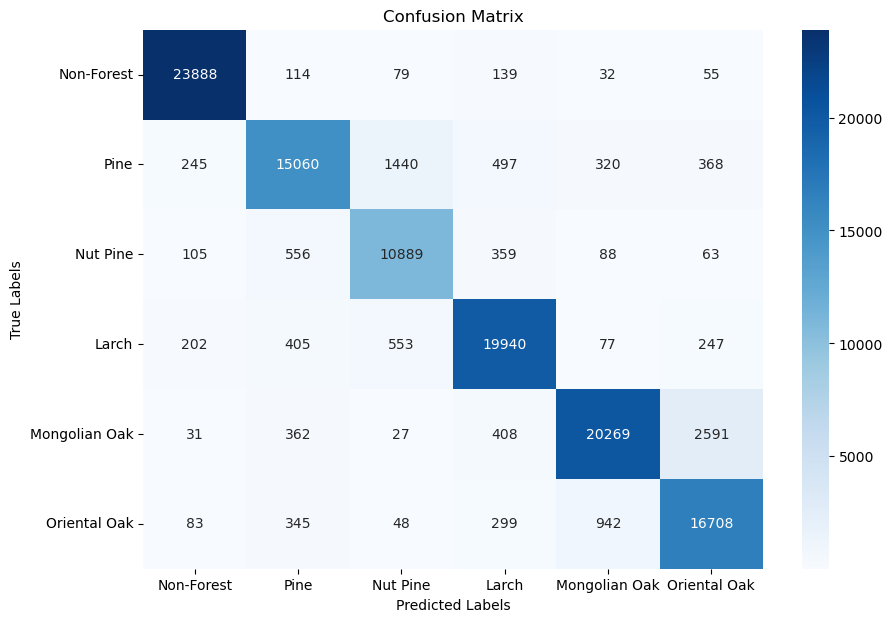

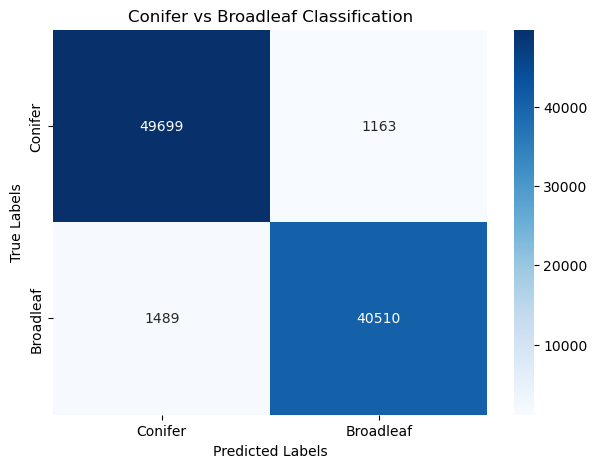

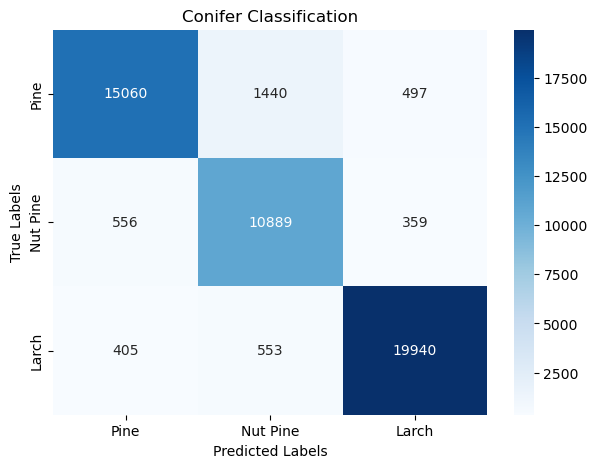

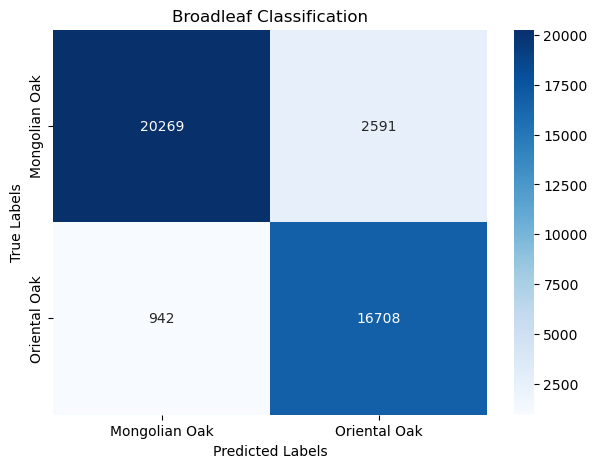


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:12<00:00, 93.41it/s]


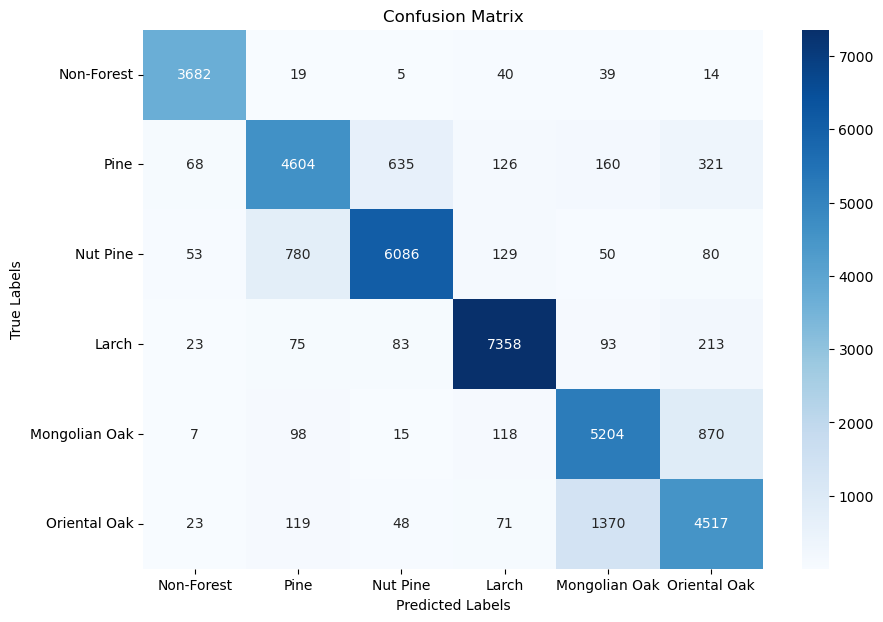

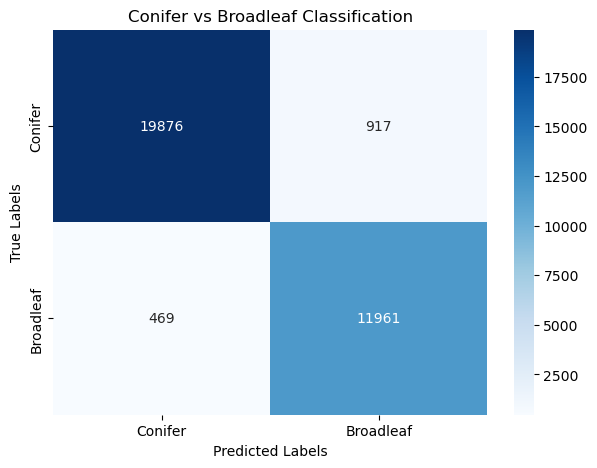

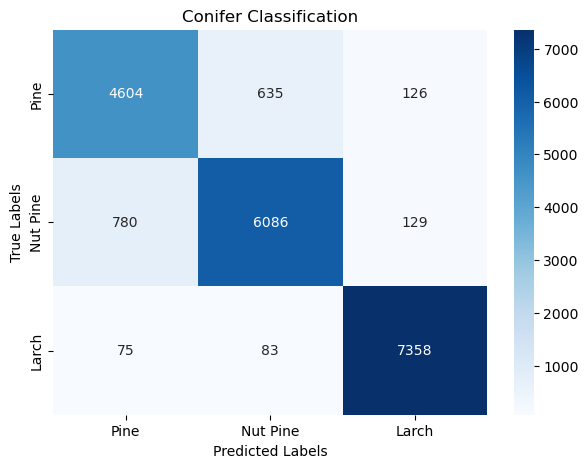

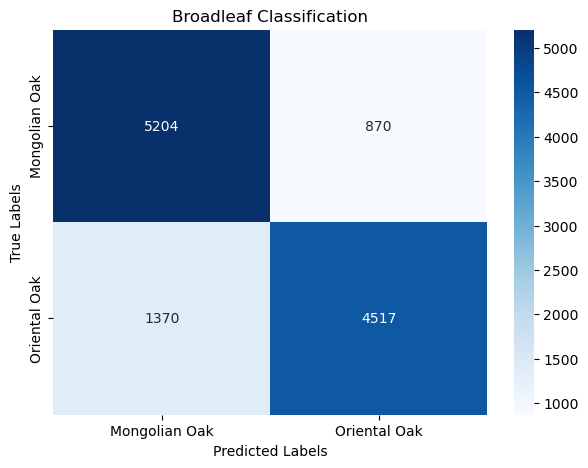

,precision,recall,f1-score,support,Category
Non-Forest,0.954876,0.969202,0.961986,3799.000000,Overall
Pine,0.808428,0.778492,0.793178,5914.000000,Overall
Nut Pine,0.885623,0.847868,0.866335,7178.000000,Overall
Larch,0.938281,0.937922,0.938102,7845.000000,Overall
Mongolian Oak,0.752458,0.824461,0.786816,6312.000000,Overall
Oriental Oak,0.750956,0.734710,0.742744,6148.000000,Overall
accuracy,0.845548,0.845548,0.845548,0.845548,Overall
macro avg,0.848437,0.848776,0.848193,37196.000000,Overall
weighted avg,0.846672,0.845548,0.845687,37196.000000,Overall
Conifer,0.976948,0.955899,0.966309,20793.000000,Conifer vs Broadleaf


In [6]:
stage_repeats = [2, 3, 5, 2]  # Stage 3이 가장 깊음
stage_channels = [8, 16, 32, 48]  # 점진적으로 증가

model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=8)
model.to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100)
os.makedirs("./checkpoints/video_classification", exist_ok=True)
torch.save(best_model_state, "./checkpoints/video_classification/VideoClassifier_4_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI 추가

In [7]:
large_tif_dir = '../../data/source_data/with_ndvi' #원천데이터 주소
bands = 5 #밴드 수

transform = get_transform(bands, scale_channels)

train_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.66it/s]



Epoch [1/100], Train Loss: 0.7308, Train Accuracy: 71.41%, Val Loss: 0.5833, Val Accuracy: 78.83%



Epoch 2/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.67it/s]



Epoch [2/100], Train Loss: 0.4883, Train Accuracy: 81.98%, Val Loss: 0.5354, Val Accuracy: 81.14%



Epoch 3/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.11it/s]



Epoch [3/100], Train Loss: 0.4146, Train Accuracy: 84.92%, Val Loss: 0.4917, Val Accuracy: 83.15%



Epoch 4/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.55it/s]



Epoch [4/100], Train Loss: 0.3711, Train Accuracy: 86.74%, Val Loss: 0.5041, Val Accuracy: 83.72%



Epoch 5/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.20it/s]



Epoch [5/100], Train Loss: 0.3396, Train Accuracy: 87.85%, Val Loss: 0.6601, Val Accuracy: 80.45%



Epoch 6/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.55it/s]



Epoch [6/100], Train Loss: 0.3106, Train Accuracy: 89.00%, Val Loss: 0.5221, Val Accuracy: 84.40%



Epoch 7/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.46it/s]



Epoch [7/100], Train Loss: 0.2932, Train Accuracy: 89.63%, Val Loss: 0.9386, Val Accuracy: 83.80%



Epoch 8/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.18it/s]



Epoch [8/100], Train Loss: 0.2784, Train Accuracy: 90.14%, Val Loss: 0.8787, Val Accuracy: 81.04%



Epoch 9/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.24it/s]



Epoch [9/100], Train Loss: 0.2646, Train Accuracy: 90.67%, Val Loss: 0.6683, Val Accuracy: 83.53%



Epoch 10/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.62it/s]



Epoch [10/100], Train Loss: 0.2514, Train Accuracy: 91.01%, Val Loss: 1.6371, Val Accuracy: 83.89%



Epoch 11/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.23it/s]



Epoch [11/100], Train Loss: 0.2447, Train Accuracy: 91.35%, Val Loss: 0.5914, Val Accuracy: 85.03%



Epoch 12/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.72it/s]



Epoch [12/100], Train Loss: 0.2361, Train Accuracy: 91.72%, Val Loss: 0.5292, Val Accuracy: 83.03%



Epoch 13/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.32it/s]



Epoch [13/100], Train Loss: 0.2269, Train Accuracy: 91.92%, Val Loss: 0.5856, Val Accuracy: 84.79%



Epoch 14/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.69it/s]



Epoch [14/100], Train Loss: 0.2211, Train Accuracy: 92.17%, Val Loss: 1.8043, Val Accuracy: 83.73%



Epoch 15/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.66it/s]



Epoch [15/100], Train Loss: 0.2136, Train Accuracy: 92.34%, Val Loss: 0.7664, Val Accuracy: 85.33%



Epoch 16/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.63it/s]



Epoch [16/100], Train Loss: 0.2086, Train Accuracy: 92.57%, Val Loss: 1.1678, Val Accuracy: 84.32%



Epoch 17/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.56it/s]



Epoch [17/100], Train Loss: 0.2044, Train Accuracy: 92.59%, Val Loss: 0.9383, Val Accuracy: 83.60%



Epoch 18/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.83it/s]



Epoch [18/100], Train Loss: 0.1989, Train Accuracy: 92.85%, Val Loss: 0.8438, Val Accuracy: 83.53%



Epoch 19/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.60it/s]



Epoch [19/100], Train Loss: 0.1939, Train Accuracy: 93.04%, Val Loss: 1.7182, Val Accuracy: 85.13%



Epoch 20/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.60it/s]



Epoch [20/100], Train Loss: 0.1891, Train Accuracy: 93.31%, Val Loss: 1.0031, Val Accuracy: 85.52%



Epoch 21/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.27it/s]



Epoch [21/100], Train Loss: 0.1866, Train Accuracy: 93.29%, Val Loss: 16.2233, Val Accuracy: 84.27%



Epoch 22/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.62it/s]



Epoch [22/100], Train Loss: 0.1821, Train Accuracy: 93.52%, Val Loss: 60.8345, Val Accuracy: 83.61%



Epoch 23/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.69it/s]



Epoch [23/100], Train Loss: 0.1783, Train Accuracy: 93.43%, Val Loss: 99.6511, Val Accuracy: 82.68%



Epoch 24/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.28it/s]



Epoch [24/100], Train Loss: 0.1751, Train Accuracy: 93.69%, Val Loss: 4.9235, Val Accuracy: 84.96%



Epoch 25/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.21it/s]



Epoch [25/100], Train Loss: 0.1716, Train Accuracy: 93.84%, Val Loss: 46.3720, Val Accuracy: 83.80%



Epoch 26/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.47it/s]



Epoch [26/100], Train Loss: 0.1657, Train Accuracy: 94.06%, Val Loss: 1.8139, Val Accuracy: 82.18%



Epoch 27/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.50it/s]



Epoch [27/100], Train Loss: 0.1642, Train Accuracy: 94.11%, Val Loss: 3.8903, Val Accuracy: 84.18%



Epoch 28/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.24it/s]



Epoch [28/100], Train Loss: 0.1619, Train Accuracy: 94.11%, Val Loss: 1.6356, Val Accuracy: 84.34%



Epoch 29/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.59it/s]



Epoch [29/100], Train Loss: 0.1595, Train Accuracy: 94.21%, Val Loss: 0.7891, Val Accuracy: 84.64%



Epoch 30/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.34it/s]



Epoch [30/100], Train Loss: 0.1561, Train Accuracy: 94.33%, Val Loss: 5.8363, Val Accuracy: 82.51%



Epoch 31/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 80.87it/s]



Epoch [31/100], Train Loss: 0.1533, Train Accuracy: 94.48%, Val Loss: 2.4116, Val Accuracy: 84.96%



Epoch 32/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.67it/s]



Epoch [32/100], Train Loss: 0.1490, Train Accuracy: 94.60%, Val Loss: 1.7837, Val Accuracy: 82.04%



Epoch 33/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.57it/s]



Epoch [33/100], Train Loss: 0.1501, Train Accuracy: 94.59%, Val Loss: 1.7315, Val Accuracy: 85.83%



Epoch 34/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.19it/s]



Epoch [34/100], Train Loss: 0.1439, Train Accuracy: 94.76%, Val Loss: 5.8112, Val Accuracy: 84.07%



Epoch 35/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.46it/s]



Epoch [35/100], Train Loss: 0.1430, Train Accuracy: 94.80%, Val Loss: 11.2106, Val Accuracy: 85.55%



Epoch 36/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.22it/s]



Epoch [36/100], Train Loss: 0.1432, Train Accuracy: 94.77%, Val Loss: 45.2946, Val Accuracy: 82.48%



Epoch 37/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.23it/s]



Epoch [37/100], Train Loss: 0.1386, Train Accuracy: 94.98%, Val Loss: 25.0985, Val Accuracy: 83.49%



Epoch 38/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.24it/s]



Epoch [38/100], Train Loss: 0.1368, Train Accuracy: 95.05%, Val Loss: 4.4566, Val Accuracy: 85.17%



Epoch 39/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.24it/s]



Epoch [39/100], Train Loss: 0.1328, Train Accuracy: 95.09%, Val Loss: 24.7093, Val Accuracy: 82.96%



Epoch 40/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.28it/s]



Epoch [40/100], Train Loss: 0.1317, Train Accuracy: 95.20%, Val Loss: 4.8385, Val Accuracy: 85.29%



Epoch 41/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.20it/s]



Epoch [41/100], Train Loss: 0.1307, Train Accuracy: 95.23%, Val Loss: 17.5554, Val Accuracy: 84.68%



Epoch 42/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.62it/s]



Epoch [42/100], Train Loss: 0.1285, Train Accuracy: 95.29%, Val Loss: 12.0717, Val Accuracy: 82.84%



Epoch 43/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 80.89it/s]



Epoch [43/100], Train Loss: 0.1270, Train Accuracy: 95.37%, Val Loss: 41.0650, Val Accuracy: 83.09%



Epoch 44/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.58it/s]



Epoch [44/100], Train Loss: 0.1252, Train Accuracy: 95.40%, Val Loss: 84.9628, Val Accuracy: 83.68%



Epoch 45/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.31it/s]



Epoch [45/100], Train Loss: 0.1227, Train Accuracy: 95.52%, Val Loss: 1.3871, Val Accuracy: 84.95%



Epoch 46/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.66it/s]



Epoch [46/100], Train Loss: 0.1197, Train Accuracy: 95.70%, Val Loss: 8.6636, Val Accuracy: 85.22%



Epoch 47/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.54it/s]



Epoch [47/100], Train Loss: 0.1203, Train Accuracy: 95.57%, Val Loss: 32.0334, Val Accuracy: 84.64%



Epoch 48/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.66it/s]



Epoch [48/100], Train Loss: 0.1169, Train Accuracy: 95.70%, Val Loss: 48.2499, Val Accuracy: 83.10%



Epoch 49/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.57it/s]



Epoch [49/100], Train Loss: 0.1158, Train Accuracy: 95.80%, Val Loss: 8.2926, Val Accuracy: 84.54%



Epoch 50/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.59it/s]



Epoch [50/100], Train Loss: 0.1127, Train Accuracy: 95.93%, Val Loss: 2.1687, Val Accuracy: 83.90%



Epoch 51/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.26it/s]



Epoch [51/100], Train Loss: 0.1131, Train Accuracy: 95.85%, Val Loss: 11.3854, Val Accuracy: 82.89%



Epoch 52/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.44it/s]



Epoch [52/100], Train Loss: 0.1109, Train Accuracy: 95.97%, Val Loss: 3.2914, Val Accuracy: 85.57%



Epoch 53/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.59it/s]



Epoch [53/100], Train Loss: 0.1101, Train Accuracy: 96.00%, Val Loss: 18.9101, Val Accuracy: 84.14%



Epoch 54/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.72it/s]



Epoch [54/100], Train Loss: 0.1077, Train Accuracy: 96.10%, Val Loss: 0.9294, Val Accuracy: 84.57%



Epoch 55/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.26it/s]



Epoch [55/100], Train Loss: 0.1066, Train Accuracy: 96.10%, Val Loss: 6.9333, Val Accuracy: 81.97%



Epoch 56/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.66it/s]



Epoch [56/100], Train Loss: 0.1046, Train Accuracy: 96.15%, Val Loss: 1.1667, Val Accuracy: 85.00%



Epoch 57/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.64it/s]



Epoch [57/100], Train Loss: 0.1039, Train Accuracy: 96.18%, Val Loss: 23.2146, Val Accuracy: 84.45%



Epoch 58/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.19it/s]



Epoch [58/100], Train Loss: 0.1042, Train Accuracy: 96.15%, Val Loss: 7.1275, Val Accuracy: 83.50%



Epoch 59/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.25it/s]



Epoch [59/100], Train Loss: 0.1006, Train Accuracy: 96.31%, Val Loss: 3.3850, Val Accuracy: 83.25%



Epoch 60/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.23it/s]



Epoch [60/100], Train Loss: 0.0994, Train Accuracy: 96.37%, Val Loss: 6.1708, Val Accuracy: 83.54%



Epoch 61/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.40it/s]



Epoch [61/100], Train Loss: 0.0993, Train Accuracy: 96.29%, Val Loss: 7.6829, Val Accuracy: 84.09%



Epoch 62/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.57it/s]



Epoch [62/100], Train Loss: 0.0962, Train Accuracy: 96.51%, Val Loss: 17.3278, Val Accuracy: 84.59%



Epoch 63/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.52it/s]



Epoch [63/100], Train Loss: 0.0957, Train Accuracy: 96.48%, Val Loss: 1.9219, Val Accuracy: 84.65%



Epoch 64/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.23it/s]



Epoch [64/100], Train Loss: 0.0938, Train Accuracy: 96.53%, Val Loss: 9.6812, Val Accuracy: 82.97%



Epoch 65/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.22it/s]



Epoch [65/100], Train Loss: 0.0936, Train Accuracy: 96.56%, Val Loss: 2.0570, Val Accuracy: 85.56%



Epoch 66/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.21it/s]



Epoch [66/100], Train Loss: 0.0920, Train Accuracy: 96.58%, Val Loss: 6.1187, Val Accuracy: 83.62%



Epoch 67/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.64it/s]



Epoch [67/100], Train Loss: 0.0924, Train Accuracy: 96.62%, Val Loss: 15.5762, Val Accuracy: 83.49%



Epoch 68/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.63it/s]



Epoch [68/100], Train Loss: 0.0904, Train Accuracy: 96.65%, Val Loss: 1.5489, Val Accuracy: 84.85%



Epoch 69/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.50it/s]



Epoch [69/100], Train Loss: 0.0895, Train Accuracy: 96.77%, Val Loss: 3.4286, Val Accuracy: 83.52%



Epoch 70/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.60it/s]



Epoch [70/100], Train Loss: 0.0881, Train Accuracy: 96.81%, Val Loss: 4.4695, Val Accuracy: 84.04%



Epoch 71/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.28it/s]



Epoch [71/100], Train Loss: 0.0864, Train Accuracy: 96.80%, Val Loss: 4.4650, Val Accuracy: 84.50%



Epoch 72/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.64it/s]



Epoch [72/100], Train Loss: 0.0857, Train Accuracy: 96.84%, Val Loss: 5.3714, Val Accuracy: 84.19%



Epoch 73/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.56it/s]



Epoch [73/100], Train Loss: 0.0844, Train Accuracy: 96.88%, Val Loss: 10.7630, Val Accuracy: 83.97%



Epoch 74/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.61it/s]



Epoch [74/100], Train Loss: 0.0835, Train Accuracy: 96.97%, Val Loss: 14.6938, Val Accuracy: 85.48%



Epoch 75/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.26it/s]



Epoch [75/100], Train Loss: 0.0860, Train Accuracy: 96.84%, Val Loss: 8.5356, Val Accuracy: 84.16%



Epoch 76/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.57it/s]



Epoch [76/100], Train Loss: 0.0823, Train Accuracy: 97.03%, Val Loss: 11.1082, Val Accuracy: 83.75%



Epoch 77/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.44it/s]



Epoch [77/100], Train Loss: 0.0816, Train Accuracy: 97.03%, Val Loss: 18.9181, Val Accuracy: 83.52%



Epoch 78/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.52it/s]



Epoch [78/100], Train Loss: 0.0806, Train Accuracy: 97.06%, Val Loss: 24.4301, Val Accuracy: 82.18%



Epoch 79/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.53it/s]



Epoch [79/100], Train Loss: 0.0795, Train Accuracy: 97.08%, Val Loss: 47.6162, Val Accuracy: 83.05%



Epoch 80/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.20it/s]



Epoch [80/100], Train Loss: 0.0785, Train Accuracy: 97.11%, Val Loss: 45.1683, Val Accuracy: 84.97%



Epoch 81/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.26it/s]



Epoch [81/100], Train Loss: 0.0779, Train Accuracy: 97.14%, Val Loss: 128.9146, Val Accuracy: 84.23%



Epoch 82/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.61it/s]



Epoch [82/100], Train Loss: 0.0766, Train Accuracy: 97.16%, Val Loss: 17.8180, Val Accuracy: 84.72%



Epoch 83/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.48it/s]



Epoch [83/100], Train Loss: 0.0753, Train Accuracy: 97.23%, Val Loss: 25.8832, Val Accuracy: 84.19%



Epoch 84/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.51it/s]



Epoch [84/100], Train Loss: 0.0750, Train Accuracy: 97.20%, Val Loss: 40.9769, Val Accuracy: 85.12%



Epoch 85/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.28it/s]



Epoch [85/100], Train Loss: 0.0735, Train Accuracy: 97.30%, Val Loss: 15.2188, Val Accuracy: 83.93%



Epoch 86/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.20it/s]



Epoch [86/100], Train Loss: 0.0744, Train Accuracy: 97.28%, Val Loss: 26.1865, Val Accuracy: 84.07%



Epoch 87/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.52it/s]



Epoch [87/100], Train Loss: 0.0730, Train Accuracy: 97.29%, Val Loss: 114.3023, Val Accuracy: 83.71%



Epoch 88/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.37it/s]



Epoch [88/100], Train Loss: 0.0723, Train Accuracy: 97.32%, Val Loss: 3.5341, Val Accuracy: 83.53%



Epoch 89/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.13it/s]



Epoch [89/100], Train Loss: 0.0707, Train Accuracy: 97.34%, Val Loss: 1.3534, Val Accuracy: 74.05%



Epoch 90/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.65it/s]



Epoch [90/100], Train Loss: 0.0696, Train Accuracy: 97.37%, Val Loss: 6.6353, Val Accuracy: 85.08%



Epoch 91/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.68it/s]



Epoch [91/100], Train Loss: 0.0683, Train Accuracy: 97.48%, Val Loss: 67.6571, Val Accuracy: 84.16%



Epoch 92/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.13it/s]



Epoch [92/100], Train Loss: 0.0681, Train Accuracy: 97.49%, Val Loss: 9.7981, Val Accuracy: 83.91%



Epoch 93/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.56it/s]



Epoch [93/100], Train Loss: 0.0664, Train Accuracy: 97.55%, Val Loss: 10.1887, Val Accuracy: 82.55%



Epoch 94/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.57it/s]



Epoch [94/100], Train Loss: 0.0680, Train Accuracy: 97.49%, Val Loss: 5.2472, Val Accuracy: 84.40%



Epoch 95/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.25it/s]



Epoch [95/100], Train Loss: 0.0671, Train Accuracy: 97.53%, Val Loss: 196.5598, Val Accuracy: 82.83%



Epoch 96/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.29it/s]



Epoch [96/100], Train Loss: 0.0662, Train Accuracy: 97.57%, Val Loss: 9.0624, Val Accuracy: 84.14%



Epoch 97/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.03it/s]



Epoch [97/100], Train Loss: 0.0640, Train Accuracy: 97.59%, Val Loss: 69.6275, Val Accuracy: 84.48%



Epoch 98/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.20it/s]



Epoch [98/100], Train Loss: 0.0643, Train Accuracy: 97.63%, Val Loss: 9.3645, Val Accuracy: 84.90%



Epoch 99/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.60it/s]



Epoch [99/100], Train Loss: 0.0630, Train Accuracy: 97.66%, Val Loss: 23.3752, Val Accuracy: 83.66%



Epoch 100/100 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 81.59it/s]



Epoch [100/100], Train Loss: 0.0646, Train Accuracy: 97.60%, Val Loss: 2282.4549, Val Accuracy: 84.86%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:45<00:00, 81.44it/s]


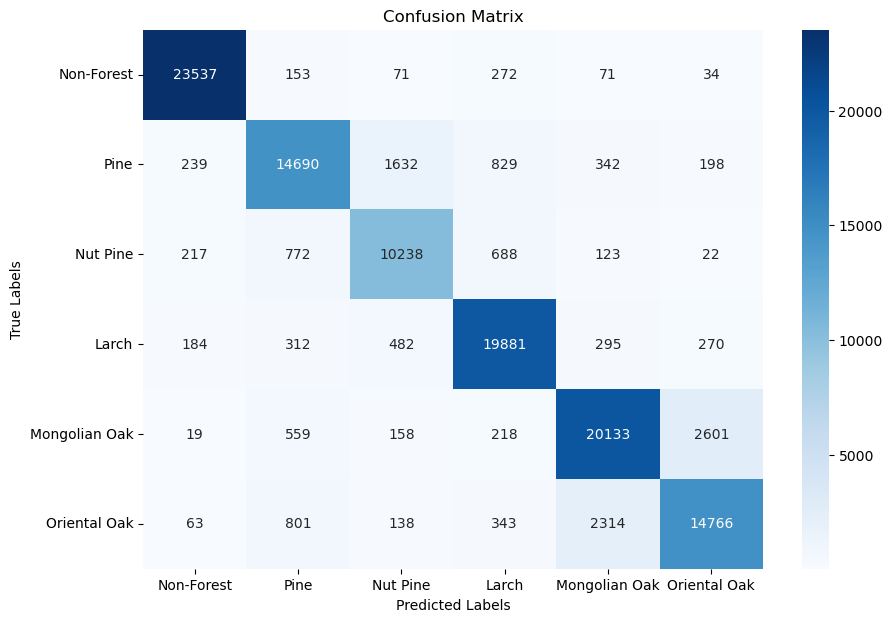

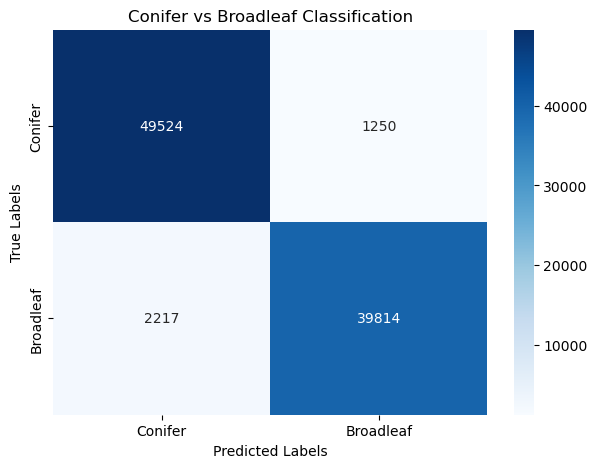

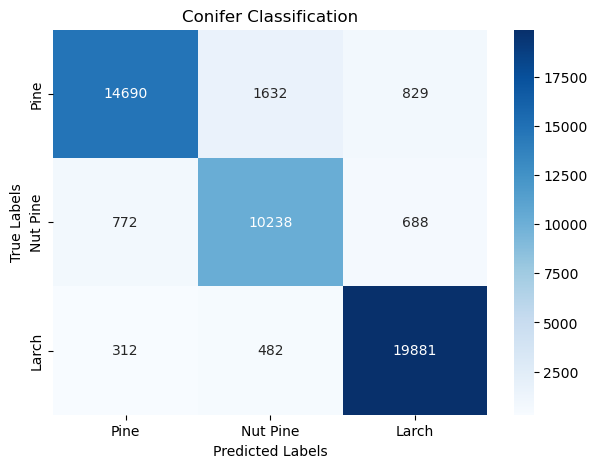

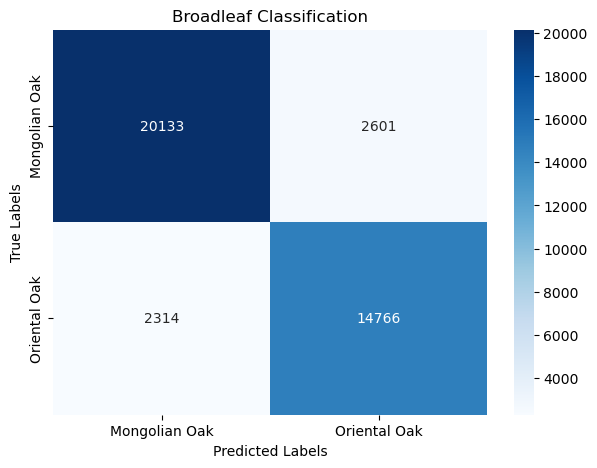


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:14<00:00, 81.66it/s]


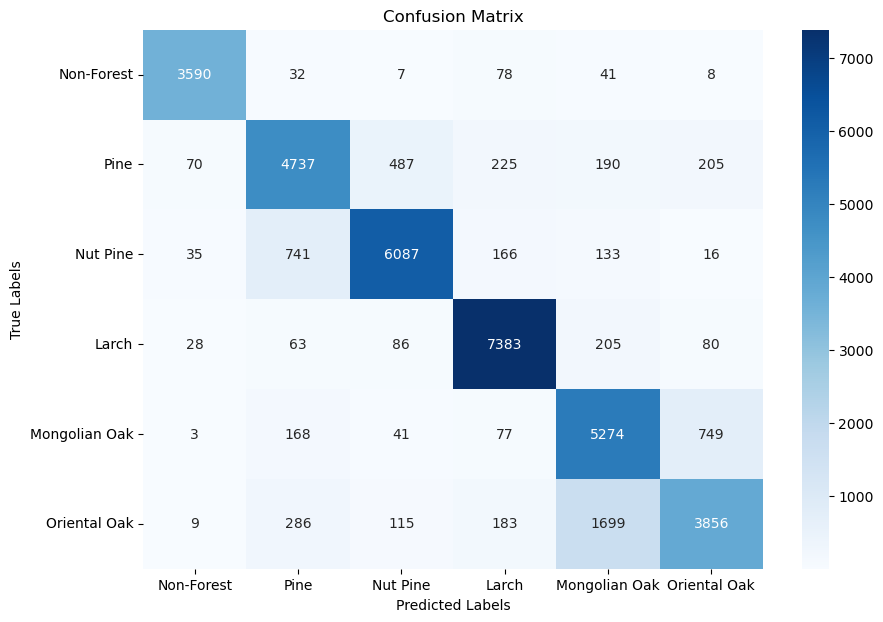

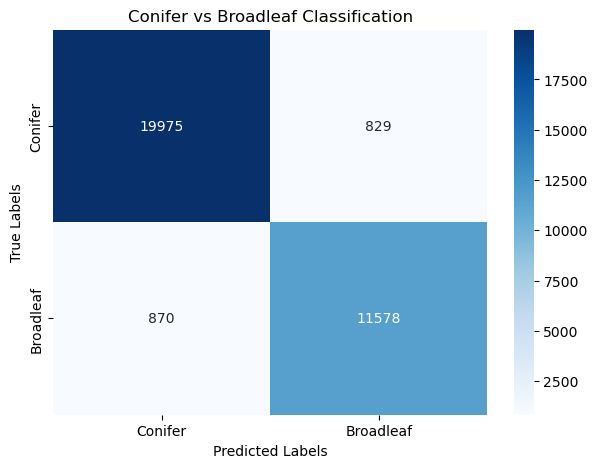

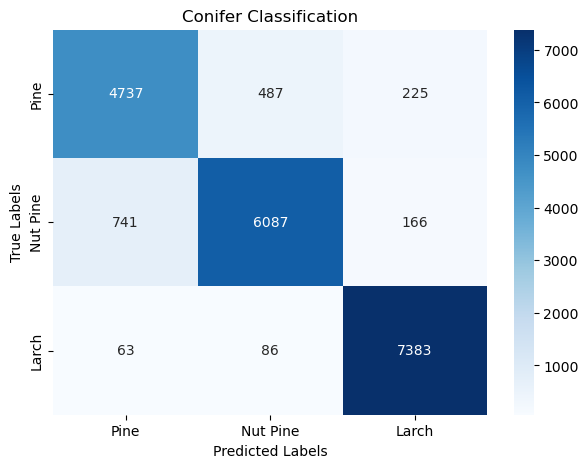

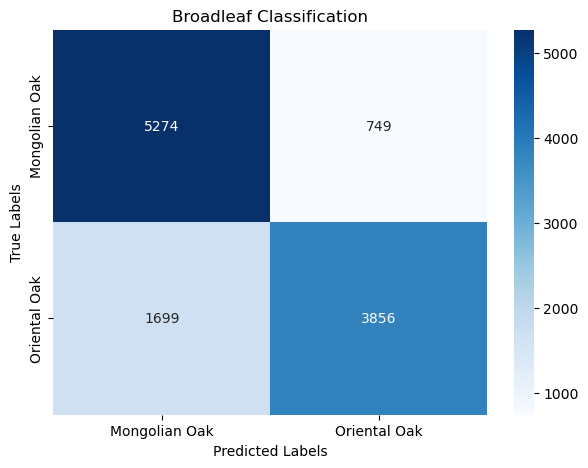

,precision,recall,f1-score,support,Category
Non-Forest,0.961178,0.944986,0.953013,3799.000000,Overall
Pine,0.785963,0.800981,0.793401,5914.000000,Overall
Nut Pine,0.892130,0.848008,0.869509,7178.000000,Overall
Larch,0.910133,0.941109,0.925362,7845.000000,Overall
Mongolian Oak,0.699284,0.835551,0.761369,6312.000000,Overall
Oriental Oak,0.784697,0.627196,0.697161,6148.000000,Overall
micro avg,0.832423,0.831460,0.831941,37196.000000,Overall
macro avg,0.838897,0.832972,0.833303,37196.000000,Overall
weighted avg,0.835617,0.831460,0.830879,37196.000000,Overall
Conifer,0.958263,0.960152,0.959207,20804.000000,Conifer vs Broadleaf


In [8]:
stage_repeats = [2, 3, 6, 3]
stage_channels = [10, 20, 40, 60]

model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=8)
model.to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100)
torch.save(best_model_state, "./checkpoints/video_classification/VideoClassifier_5_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI, Sentinel_2(B05, B06, B07, B11, B12) 데이터 추가

In [7]:
large_tif_dir = '../../data/source_data/with_ndvi_s2' #원천데이터 주소
bands = 10 #밴드 수

transform = get_transform(bands, scale_channels)

train_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.14it/s]



Epoch [1/100], Train Loss: 0.6593, Train Accuracy: 74.16%, Val Loss: 0.6016, Val Accuracy: 76.56%



Epoch 2/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.09it/s]



Epoch [2/100], Train Loss: 0.4345, Train Accuracy: 84.22%, Val Loss: 0.5204, Val Accuracy: 83.52%



Epoch 3/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.28it/s]



Epoch [3/100], Train Loss: 0.3532, Train Accuracy: 87.37%, Val Loss: 0.9209, Val Accuracy: 77.05%



Epoch 4/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.71it/s]



Epoch [4/100], Train Loss: 0.3029, Train Accuracy: 89.32%, Val Loss: 0.7796, Val Accuracy: 74.99%



Epoch 5/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.78it/s]



Epoch [5/100], Train Loss: 0.2727, Train Accuracy: 90.44%, Val Loss: 0.7477, Val Accuracy: 79.52%



Epoch 6/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.10it/s]



Epoch [6/100], Train Loss: 0.2453, Train Accuracy: 91.38%, Val Loss: 1.7528, Val Accuracy: 80.06%



Epoch 7/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.87it/s]



Epoch [7/100], Train Loss: 0.2338, Train Accuracy: 91.83%, Val Loss: 0.4277, Val Accuracy: 87.77%



Epoch 8/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.70it/s]



Epoch [8/100], Train Loss: 0.2141, Train Accuracy: 92.47%, Val Loss: 0.8661, Val Accuracy: 84.17%



Epoch 9/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.38it/s]



Epoch [9/100], Train Loss: 0.2029, Train Accuracy: 92.78%, Val Loss: 3.7874, Val Accuracy: 85.61%



Epoch 10/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.84it/s]



Epoch [10/100], Train Loss: 0.1921, Train Accuracy: 93.22%, Val Loss: 2.0023, Val Accuracy: 84.74%



Epoch 11/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.68it/s]



Epoch [11/100], Train Loss: 0.1843, Train Accuracy: 93.52%, Val Loss: 11.9261, Val Accuracy: 82.25%



Epoch 12/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.82it/s]



Epoch [12/100], Train Loss: 0.1785, Train Accuracy: 93.75%, Val Loss: 3.6358, Val Accuracy: 85.38%



Epoch 13/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.32it/s]



Epoch [13/100], Train Loss: 0.1723, Train Accuracy: 93.96%, Val Loss: 5.1086, Val Accuracy: 85.66%



Epoch 14/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.86it/s]



Epoch [14/100], Train Loss: 0.1628, Train Accuracy: 94.28%, Val Loss: 11.4971, Val Accuracy: 78.68%



Epoch 15/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.63it/s]



Epoch [15/100], Train Loss: 0.1557, Train Accuracy: 94.50%, Val Loss: 7.5450, Val Accuracy: 86.71%



Epoch 16/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.23it/s]



Epoch [16/100], Train Loss: 0.1488, Train Accuracy: 94.76%, Val Loss: 27.5796, Val Accuracy: 84.51%



Epoch 17/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.88it/s]



Epoch [17/100], Train Loss: 0.1457, Train Accuracy: 94.87%, Val Loss: 291.7950, Val Accuracy: 81.82%



Epoch 18/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.87it/s]



Epoch [18/100], Train Loss: 0.1403, Train Accuracy: 95.00%, Val Loss: 167.6223, Val Accuracy: 85.26%



Epoch 19/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.10it/s]



Epoch [19/100], Train Loss: 0.1392, Train Accuracy: 95.10%, Val Loss: 218.5380, Val Accuracy: 85.43%



Epoch 20/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.12it/s]



Epoch [20/100], Train Loss: 0.1307, Train Accuracy: 95.38%, Val Loss: 59.0181, Val Accuracy: 86.39%



Epoch 21/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.11it/s]



Epoch [21/100], Train Loss: 0.1264, Train Accuracy: 95.49%, Val Loss: 397.9071, Val Accuracy: 84.90%



Epoch 22/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.10it/s]



Epoch [22/100], Train Loss: 0.1258, Train Accuracy: 95.59%, Val Loss: 18.4560, Val Accuracy: 82.89%



Epoch 23/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.07it/s]



Epoch [23/100], Train Loss: 0.1208, Train Accuracy: 95.69%, Val Loss: 16.7790, Val Accuracy: 84.83%



Epoch 24/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.83it/s]



Epoch [24/100], Train Loss: 0.1181, Train Accuracy: 95.76%, Val Loss: 594.2164, Val Accuracy: 85.84%



Epoch 25/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.02it/s]



Epoch [25/100], Train Loss: 0.1136, Train Accuracy: 96.00%, Val Loss: 264.7205, Val Accuracy: 87.18%



Epoch 26/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.92it/s]



Epoch [26/100], Train Loss: 0.1104, Train Accuracy: 96.11%, Val Loss: 24533.7727, Val Accuracy: 84.30%



Epoch 27/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.92it/s]



Epoch [27/100], Train Loss: 0.1084, Train Accuracy: 96.18%, Val Loss: 2044.9744, Val Accuracy: 79.93%



Epoch 28/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.08it/s]



Epoch [28/100], Train Loss: 0.1051, Train Accuracy: 96.28%, Val Loss: 3469.3043, Val Accuracy: 83.41%



Epoch 29/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.88it/s]



Epoch [29/100], Train Loss: 0.1020, Train Accuracy: 96.36%, Val Loss: 939.0903, Val Accuracy: 84.93%



Epoch 30/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.54it/s]



Epoch [30/100], Train Loss: 0.1010, Train Accuracy: 96.47%, Val Loss: 2449.0890, Val Accuracy: 85.89%



Epoch 31/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.40it/s]



Epoch [31/100], Train Loss: 0.0981, Train Accuracy: 96.49%, Val Loss: 121.1032, Val Accuracy: 85.95%



Epoch 32/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.80it/s]



Epoch [32/100], Train Loss: 0.0967, Train Accuracy: 96.55%, Val Loss: 738.9513, Val Accuracy: 85.79%



Epoch 33/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.68it/s]



Epoch [33/100], Train Loss: 0.0937, Train Accuracy: 96.67%, Val Loss: 432.7422, Val Accuracy: 86.80%



Epoch 34/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.77it/s]



Epoch [34/100], Train Loss: 0.0916, Train Accuracy: 96.76%, Val Loss: 189.0896, Val Accuracy: 87.57%



Epoch 35/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.11it/s]



Epoch [35/100], Train Loss: 0.0884, Train Accuracy: 96.81%, Val Loss: 2777.0233, Val Accuracy: 85.53%



Epoch 36/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.98it/s]



Epoch [36/100], Train Loss: 0.0873, Train Accuracy: 96.88%, Val Loss: 335.6373, Val Accuracy: 81.17%



Epoch 37/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.09it/s]



Epoch [37/100], Train Loss: 0.0868, Train Accuracy: 96.86%, Val Loss: 593.9048, Val Accuracy: 84.93%



Epoch 38/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.83it/s]



Epoch [38/100], Train Loss: 0.0857, Train Accuracy: 96.94%, Val Loss: 240.0861, Val Accuracy: 84.06%



Epoch 39/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.12it/s]



Epoch [39/100], Train Loss: 0.0834, Train Accuracy: 96.98%, Val Loss: 896.2028, Val Accuracy: 85.91%



Epoch 40/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.91it/s]



Epoch [40/100], Train Loss: 0.0814, Train Accuracy: 97.01%, Val Loss: 0.5791, Val Accuracy: 87.18%



Epoch 41/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.05it/s]



Epoch [41/100], Train Loss: 0.0789, Train Accuracy: 97.19%, Val Loss: 1.9010, Val Accuracy: 86.14%



Epoch 42/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.91it/s]



Epoch [42/100], Train Loss: 0.0807, Train Accuracy: 97.10%, Val Loss: 0.6711, Val Accuracy: 87.59%



Epoch 43/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.08it/s]



Epoch [43/100], Train Loss: 0.0778, Train Accuracy: 97.22%, Val Loss: 1.1016, Val Accuracy: 85.10%



Epoch 44/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.96it/s]



Epoch [44/100], Train Loss: 0.0770, Train Accuracy: 97.25%, Val Loss: 1.1041, Val Accuracy: 87.53%



Epoch 45/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.10it/s]



Epoch [45/100], Train Loss: 0.0735, Train Accuracy: 97.36%, Val Loss: 1.2394, Val Accuracy: 86.89%



Epoch 46/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.91it/s]



Epoch [46/100], Train Loss: 0.0712, Train Accuracy: 97.46%, Val Loss: 3.8870, Val Accuracy: 86.79%



Epoch 47/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.59it/s]



Epoch [47/100], Train Loss: 0.0711, Train Accuracy: 97.43%, Val Loss: 46.8304, Val Accuracy: 86.59%



Epoch 48/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.75it/s]



Epoch [48/100], Train Loss: 0.0710, Train Accuracy: 97.44%, Val Loss: 1.6118, Val Accuracy: 86.50%



Epoch 49/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.85it/s]



Epoch [49/100], Train Loss: 0.0693, Train Accuracy: 97.50%, Val Loss: 1.8858, Val Accuracy: 87.16%



Epoch 50/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.98it/s]



Epoch [50/100], Train Loss: 0.0682, Train Accuracy: 97.53%, Val Loss: 26.1292, Val Accuracy: 85.95%



Epoch 51/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.91it/s]



Epoch [51/100], Train Loss: 0.0661, Train Accuracy: 97.62%, Val Loss: 7.3779, Val Accuracy: 85.94%



Epoch 52/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.09it/s]



Epoch [52/100], Train Loss: 0.0657, Train Accuracy: 97.62%, Val Loss: 27.8406, Val Accuracy: 84.35%



Epoch 53/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.92it/s]



Epoch [53/100], Train Loss: 0.0653, Train Accuracy: 97.65%, Val Loss: 10.4170, Val Accuracy: 87.23%



Epoch 54/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.98it/s]



Epoch [54/100], Train Loss: 0.0648, Train Accuracy: 97.69%, Val Loss: 4.8564, Val Accuracy: 87.22%



Epoch 55/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.88it/s]



Epoch [55/100], Train Loss: 0.0637, Train Accuracy: 97.73%, Val Loss: 6.1151, Val Accuracy: 86.71%



Epoch 56/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.80it/s]



Epoch [56/100], Train Loss: 0.0618, Train Accuracy: 97.80%, Val Loss: 1.0397, Val Accuracy: 85.32%



Epoch 57/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.14it/s]



Epoch [57/100], Train Loss: 0.0605, Train Accuracy: 97.85%, Val Loss: 3.9694, Val Accuracy: 86.37%



Epoch 58/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.62it/s]



Epoch [58/100], Train Loss: 0.0589, Train Accuracy: 97.87%, Val Loss: 1.2422, Val Accuracy: 84.25%



Epoch 59/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.63it/s]



Epoch [59/100], Train Loss: 0.0594, Train Accuracy: 97.84%, Val Loss: 3.1732, Val Accuracy: 86.18%



Epoch 60/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.26it/s]



Epoch [60/100], Train Loss: 0.0587, Train Accuracy: 97.91%, Val Loss: 0.7997, Val Accuracy: 87.43%



Epoch 61/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.94it/s]



Epoch [61/100], Train Loss: 0.0575, Train Accuracy: 97.91%, Val Loss: 0.7313, Val Accuracy: 86.99%



Epoch 62/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.88it/s]



Epoch [62/100], Train Loss: 0.0554, Train Accuracy: 98.03%, Val Loss: 1.2572, Val Accuracy: 88.19%



Epoch 63/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.70it/s]



Epoch [63/100], Train Loss: 0.0562, Train Accuracy: 97.96%, Val Loss: 1.9409, Val Accuracy: 85.88%



Epoch 64/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.19it/s]



Epoch [64/100], Train Loss: 0.0544, Train Accuracy: 98.03%, Val Loss: 2.2608, Val Accuracy: 87.97%



Epoch 65/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.63it/s]



Epoch [65/100], Train Loss: 0.0542, Train Accuracy: 98.05%, Val Loss: 3.5937, Val Accuracy: 85.59%



Epoch 66/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.75it/s]



Epoch [66/100], Train Loss: 0.0541, Train Accuracy: 98.06%, Val Loss: 2.0361, Val Accuracy: 86.26%



Epoch 67/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.03it/s]



Epoch [67/100], Train Loss: 0.0523, Train Accuracy: 98.08%, Val Loss: 7.6219, Val Accuracy: 87.08%



Epoch 68/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.69it/s]



Epoch [68/100], Train Loss: 0.0516, Train Accuracy: 98.13%, Val Loss: 5.1975, Val Accuracy: 79.92%



Epoch 69/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.73it/s]



Epoch [69/100], Train Loss: 0.0515, Train Accuracy: 98.16%, Val Loss: 1.0230, Val Accuracy: 86.63%



Epoch 70/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.68it/s]



Epoch [70/100], Train Loss: 0.0509, Train Accuracy: 98.18%, Val Loss: 3.4108, Val Accuracy: 85.29%



Epoch 71/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.21it/s]



Epoch [71/100], Train Loss: 0.0496, Train Accuracy: 98.20%, Val Loss: 3.0535, Val Accuracy: 86.52%



Epoch 72/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.70it/s]



Epoch [72/100], Train Loss: 0.0485, Train Accuracy: 98.26%, Val Loss: 4.0613, Val Accuracy: 84.10%



Epoch 73/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.81it/s]



Epoch [73/100], Train Loss: 0.0480, Train Accuracy: 98.28%, Val Loss: 7.1921, Val Accuracy: 86.15%



Epoch 74/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.14it/s]



Epoch [74/100], Train Loss: 0.0493, Train Accuracy: 98.23%, Val Loss: 0.8439, Val Accuracy: 86.37%



Epoch 75/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.69it/s]



Epoch [75/100], Train Loss: 0.0463, Train Accuracy: 98.33%, Val Loss: 4.7891, Val Accuracy: 83.92%



Epoch 76/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.72it/s]



Epoch [76/100], Train Loss: 0.0470, Train Accuracy: 98.31%, Val Loss: 1.0110, Val Accuracy: 85.35%



Epoch 77/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.90it/s]



Epoch [77/100], Train Loss: 0.0466, Train Accuracy: 98.32%, Val Loss: 1.2063, Val Accuracy: 86.16%



Epoch 78/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.28it/s]



Epoch [78/100], Train Loss: 0.0461, Train Accuracy: 98.34%, Val Loss: 1.7312, Val Accuracy: 85.88%



Epoch 79/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.87it/s]



Epoch [79/100], Train Loss: 0.0442, Train Accuracy: 98.43%, Val Loss: 2.5652, Val Accuracy: 84.04%



Epoch 80/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.66it/s]



Epoch [80/100], Train Loss: 0.0451, Train Accuracy: 98.36%, Val Loss: 0.7178, Val Accuracy: 86.74%



Epoch 81/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.05it/s]



Epoch [81/100], Train Loss: 0.0437, Train Accuracy: 98.38%, Val Loss: 0.8786, Val Accuracy: 87.57%



Epoch 82/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.84it/s]



Epoch [82/100], Train Loss: 0.0433, Train Accuracy: 98.43%, Val Loss: 2.2033, Val Accuracy: 85.61%



Epoch 83/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.98it/s]



Epoch [83/100], Train Loss: 0.0421, Train Accuracy: 98.46%, Val Loss: 0.8492, Val Accuracy: 86.68%



Epoch 84/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.86it/s]



Epoch [84/100], Train Loss: 0.0423, Train Accuracy: 98.45%, Val Loss: 0.9104, Val Accuracy: 87.06%



Epoch 85/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.81it/s]



Epoch [85/100], Train Loss: 0.0416, Train Accuracy: 98.50%, Val Loss: 0.7378, Val Accuracy: 86.72%



Epoch 86/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.69it/s]



Epoch [86/100], Train Loss: 0.0414, Train Accuracy: 98.49%, Val Loss: 0.7631, Val Accuracy: 85.90%



Epoch 87/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.78it/s]



Epoch [87/100], Train Loss: 0.0413, Train Accuracy: 98.52%, Val Loss: 0.8843, Val Accuracy: 85.94%



Epoch 88/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.16it/s]



Epoch [88/100], Train Loss: 0.0405, Train Accuracy: 98.53%, Val Loss: 2.7817, Val Accuracy: 85.84%



Epoch 89/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.69it/s]



Epoch [89/100], Train Loss: 0.0388, Train Accuracy: 98.60%, Val Loss: 1.8850, Val Accuracy: 87.09%



Epoch 90/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.80it/s]



Epoch [90/100], Train Loss: 0.0393, Train Accuracy: 98.55%, Val Loss: 1.5516, Val Accuracy: 85.60%



Epoch 91/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.32it/s]



Epoch [91/100], Train Loss: 0.0377, Train Accuracy: 98.66%, Val Loss: 1.3082, Val Accuracy: 87.09%



Epoch 92/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.65it/s]



Epoch [92/100], Train Loss: 0.0384, Train Accuracy: 98.66%, Val Loss: 0.7319, Val Accuracy: 87.77%



Epoch 93/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.86it/s]



Epoch [93/100], Train Loss: 0.0382, Train Accuracy: 98.61%, Val Loss: 1.0195, Val Accuracy: 83.72%



Epoch 94/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.68it/s]



Epoch [94/100], Train Loss: 0.0387, Train Accuracy: 98.61%, Val Loss: 1.5791, Val Accuracy: 85.46%



Epoch 95/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.30it/s]



Epoch [95/100], Train Loss: 0.0384, Train Accuracy: 98.61%, Val Loss: 1.3770, Val Accuracy: 85.48%



Epoch 96/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.71it/s]



Epoch [96/100], Train Loss: 0.0373, Train Accuracy: 98.66%, Val Loss: 0.8186, Val Accuracy: 86.41%



Epoch 97/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.63it/s]



Epoch [97/100], Train Loss: 0.0363, Train Accuracy: 98.70%, Val Loss: 0.8150, Val Accuracy: 86.88%



Epoch 98/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.05it/s]



Epoch [98/100], Train Loss: 0.0360, Train Accuracy: 98.70%, Val Loss: 0.9376, Val Accuracy: 87.39%



Epoch 99/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 75.85it/s]



Epoch [99/100], Train Loss: 0.0357, Train Accuracy: 98.73%, Val Loss: 0.9374, Val Accuracy: 82.78%



Epoch 100/100 - Validation: 100%|██████████| 1163/1163 [00:15<00:00, 74.64it/s]



Epoch [100/100], Train Loss: 0.0365, Train Accuracy: 98.70%, Val Loss: 0.7745, Val Accuracy: 86.85%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:49<00:00, 74.93it/s]


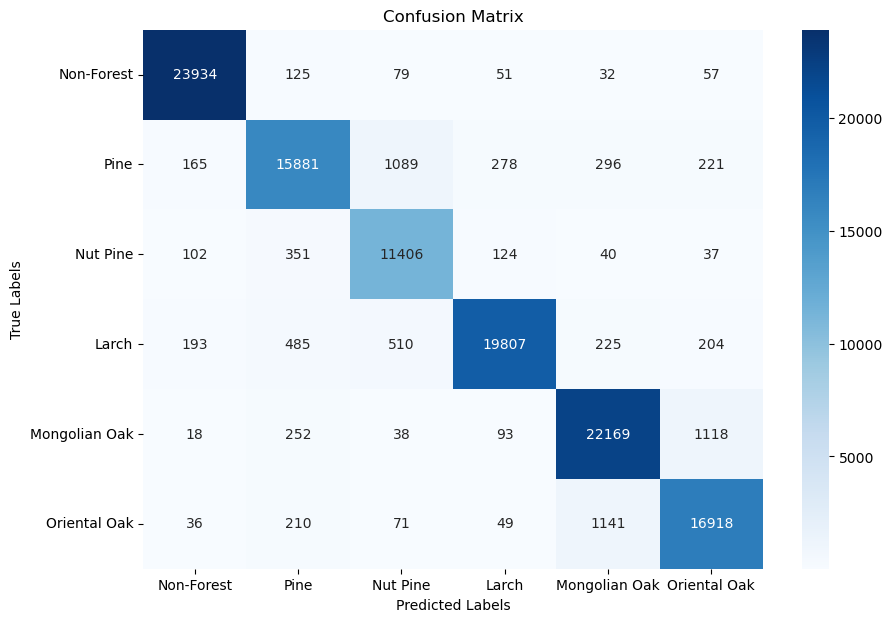

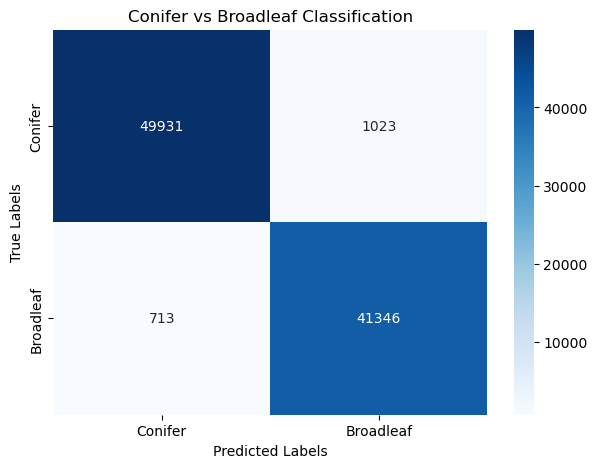

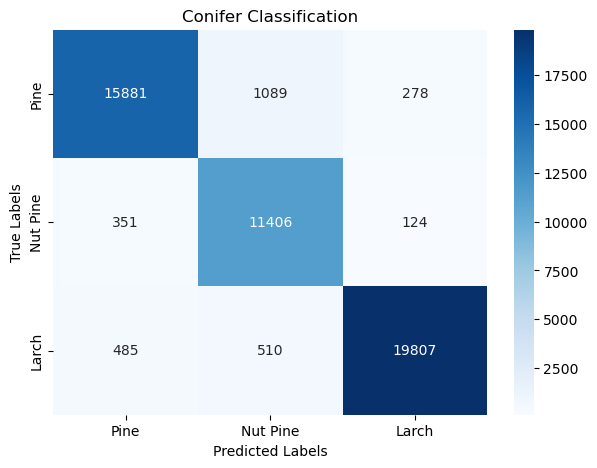

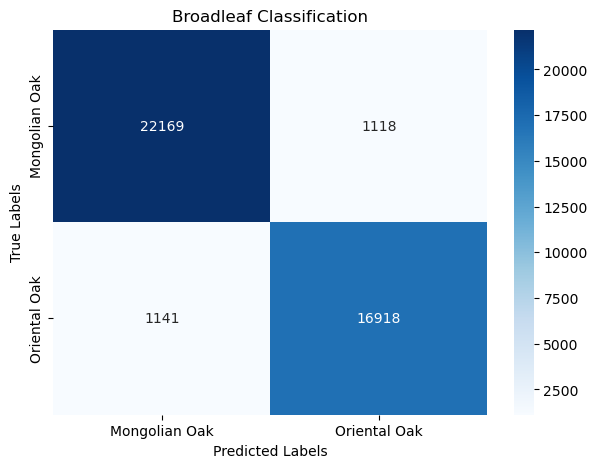


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:15<00:00, 74.99it/s]


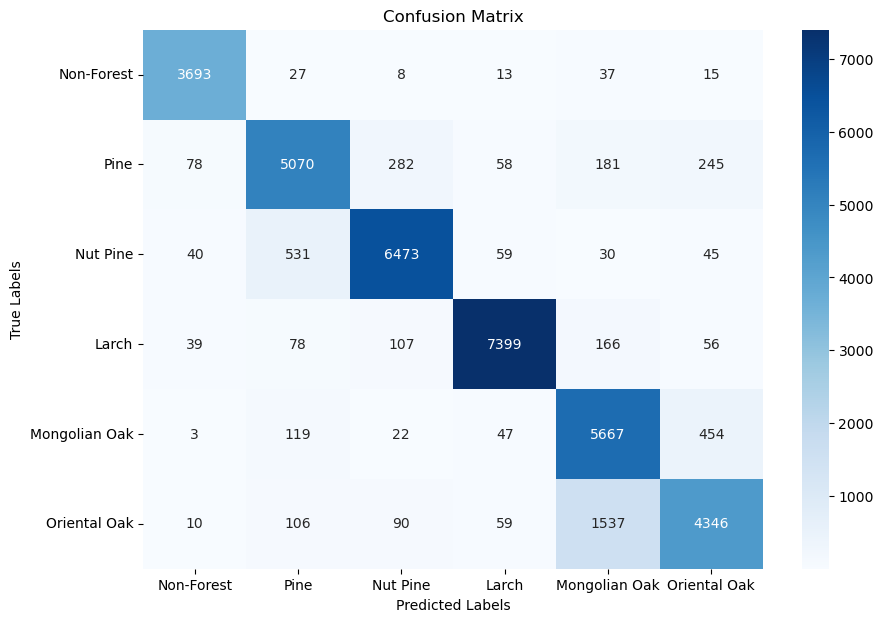

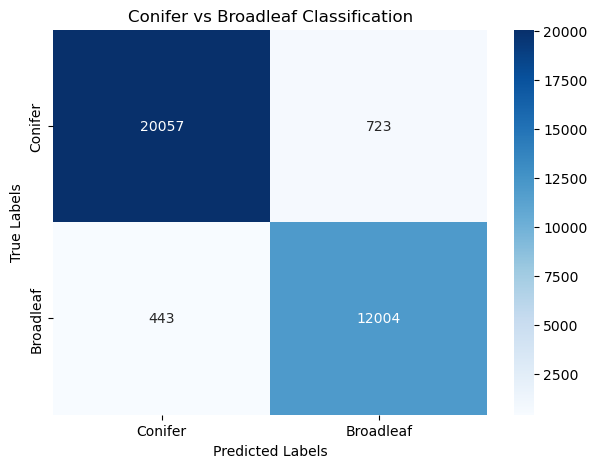

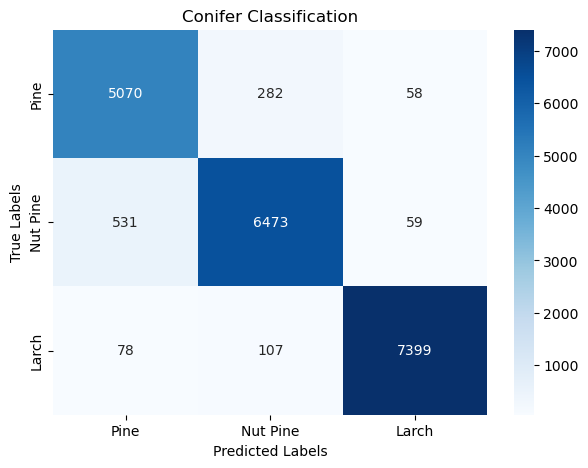

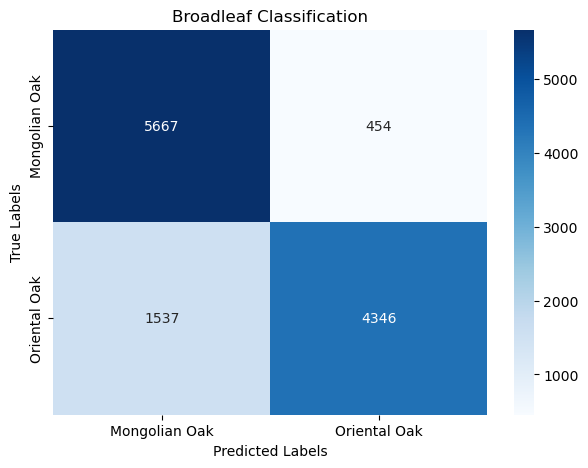

,precision,recall,f1-score,support,Category
Non-Forest,0.955993,0.972098,0.963978,3799.000000,Overall
Pine,0.854831,0.857288,0.856057,5914.000000,Overall
Nut Pine,0.927098,0.901783,0.914266,7178.000000,Overall
Larch,0.969090,0.943149,0.955943,7845.000000,Overall
Mongolian Oak,0.743896,0.897814,0.813640,6312.000000,Overall
Oriental Oak,0.842085,0.706897,0.768591,6148.000000,Overall
micro avg,0.877870,0.877729,0.877800,37196.000000,Overall
macro avg,0.882165,0.879838,0.878746,37196.000000,Overall
weighted avg,0.882275,0.877729,0.877725,37196.000000,Overall
Conifer,0.978390,0.965207,0.971754,20780.000000,Conifer vs Broadleaf


In [ ]:
stage_repeats = [3, 4, 6, 3]
stage_channels = [16, 32, 64, 96]

model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=8)
model.to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100)
torch.save(best_model_state, "./checkpoints/video_classification/VideoClassifier_10_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI 없이 Planet + Sentinel_2 데이터 사용

In [5]:
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소
bands = 9 #밴드 수

transform = get_transform(bands, scale_channels)

train_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.55it/s]



Epoch [1/100], Train Loss: 0.7216, Train Accuracy: 71.87%, Val Loss: 0.5745, Val Accuracy: 79.33%



Epoch 2/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.54it/s]



Epoch [2/100], Train Loss: 0.4559, Train Accuracy: 83.19%, Val Loss: 0.4851, Val Accuracy: 83.25%



Epoch 3/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.73it/s]



Epoch [3/100], Train Loss: 0.3803, Train Accuracy: 86.26%, Val Loss: 0.7116, Val Accuracy: 74.77%



Epoch 4/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.74it/s]



Epoch [4/100], Train Loss: 0.3297, Train Accuracy: 88.10%, Val Loss: 0.4442, Val Accuracy: 85.05%



Epoch 5/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.69it/s]



Epoch [5/100], Train Loss: 0.2986, Train Accuracy: 89.36%, Val Loss: 0.4982, Val Accuracy: 84.30%



Epoch 6/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.47it/s]



Epoch [6/100], Train Loss: 0.2687, Train Accuracy: 90.38%, Val Loss: 0.4665, Val Accuracy: 85.45%



Epoch 7/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.53it/s]



Epoch [7/100], Train Loss: 0.2459, Train Accuracy: 91.23%, Val Loss: 3.5560, Val Accuracy: 85.19%



Epoch 8/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.41it/s]



Epoch [8/100], Train Loss: 0.2367, Train Accuracy: 91.69%, Val Loss: 3.2825, Val Accuracy: 81.15%



Epoch 9/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.49it/s]



Epoch [9/100], Train Loss: 0.2268, Train Accuracy: 91.95%, Val Loss: 0.5082, Val Accuracy: 85.02%



Epoch 10/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.53it/s]



Epoch [10/100], Train Loss: 0.2123, Train Accuracy: 92.55%, Val Loss: 3.9779, Val Accuracy: 84.23%



Epoch 11/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.58it/s]



Epoch [11/100], Train Loss: 0.1999, Train Accuracy: 92.98%, Val Loss: 0.4763, Val Accuracy: 85.99%



Epoch 12/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.55it/s]



Epoch [12/100], Train Loss: 0.1930, Train Accuracy: 93.19%, Val Loss: 0.5652, Val Accuracy: 85.08%



Epoch 13/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.48it/s]



Epoch [13/100], Train Loss: 0.1889, Train Accuracy: 93.31%, Val Loss: 2.3342, Val Accuracy: 85.19%



Epoch 14/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.54it/s]



Epoch [14/100], Train Loss: 0.1780, Train Accuracy: 93.76%, Val Loss: 18.2575, Val Accuracy: 81.51%



Epoch 15/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.62it/s]



Epoch [15/100], Train Loss: 0.1838, Train Accuracy: 93.51%, Val Loss: 2.5659, Val Accuracy: 85.03%



Epoch 16/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.74it/s]



Epoch [16/100], Train Loss: 0.1662, Train Accuracy: 94.12%, Val Loss: 26.1494, Val Accuracy: 85.23%



Epoch 17/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.54it/s]



Epoch [17/100], Train Loss: 0.1588, Train Accuracy: 94.34%, Val Loss: 2.5242, Val Accuracy: 85.25%



Epoch 18/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.67it/s]



Epoch [18/100], Train Loss: 0.1546, Train Accuracy: 94.49%, Val Loss: 3.4541, Val Accuracy: 85.16%



Epoch 19/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.39it/s]



Epoch [19/100], Train Loss: 0.1477, Train Accuracy: 94.78%, Val Loss: 0.6504, Val Accuracy: 84.85%



Epoch 20/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.45it/s]



Epoch [20/100], Train Loss: 0.1439, Train Accuracy: 94.90%, Val Loss: 0.8936, Val Accuracy: 84.61%



Epoch 21/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.95it/s]



Epoch [21/100], Train Loss: 0.1386, Train Accuracy: 95.07%, Val Loss: 0.5550, Val Accuracy: 85.70%



Epoch 22/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.40it/s]



Epoch [22/100], Train Loss: 0.1346, Train Accuracy: 95.20%, Val Loss: 0.4816, Val Accuracy: 87.43%



Epoch 23/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.90it/s]



Epoch [23/100], Train Loss: 0.1292, Train Accuracy: 95.40%, Val Loss: 0.5554, Val Accuracy: 85.93%



Epoch 24/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.44it/s]



Epoch [24/100], Train Loss: 0.1271, Train Accuracy: 95.40%, Val Loss: 0.5647, Val Accuracy: 86.21%



Epoch 25/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.20it/s]



Epoch [25/100], Train Loss: 0.1230, Train Accuracy: 95.62%, Val Loss: 0.5744, Val Accuracy: 85.84%



Epoch 26/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.42it/s]



Epoch [26/100], Train Loss: 0.1202, Train Accuracy: 95.71%, Val Loss: 0.6066, Val Accuracy: 85.47%



Epoch 27/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.45it/s]



Epoch [27/100], Train Loss: 0.1154, Train Accuracy: 95.92%, Val Loss: 0.6613, Val Accuracy: 85.48%



Epoch 28/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.91it/s]



Epoch [28/100], Train Loss: 0.1138, Train Accuracy: 95.92%, Val Loss: 0.5903, Val Accuracy: 86.34%



Epoch 29/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.42it/s]



Epoch [29/100], Train Loss: 0.1117, Train Accuracy: 96.02%, Val Loss: 0.6018, Val Accuracy: 86.32%



Epoch 30/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.95it/s]



Epoch [30/100], Train Loss: 0.1083, Train Accuracy: 96.16%, Val Loss: 0.6133, Val Accuracy: 86.19%



Epoch 31/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.46it/s]



Epoch [31/100], Train Loss: 0.1051, Train Accuracy: 96.24%, Val Loss: 0.7567, Val Accuracy: 83.90%



Epoch 32/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.38it/s]



Epoch [32/100], Train Loss: 0.1036, Train Accuracy: 96.33%, Val Loss: 0.6331, Val Accuracy: 85.71%



Epoch 33/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.03it/s]



Epoch [33/100], Train Loss: 0.1012, Train Accuracy: 96.36%, Val Loss: 0.6838, Val Accuracy: 86.01%



Epoch 34/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.79it/s]



Epoch [34/100], Train Loss: 0.0994, Train Accuracy: 96.51%, Val Loss: 0.8057, Val Accuracy: 84.14%



Epoch 35/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.87it/s]



Epoch [35/100], Train Loss: 0.0970, Train Accuracy: 96.49%, Val Loss: 0.7100, Val Accuracy: 84.93%



Epoch 36/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.78it/s]



Epoch [36/100], Train Loss: 0.0962, Train Accuracy: 96.58%, Val Loss: 0.7092, Val Accuracy: 85.83%



Epoch 37/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.52it/s]



Epoch [37/100], Train Loss: 0.0923, Train Accuracy: 96.70%, Val Loss: 0.7153, Val Accuracy: 84.39%



Epoch 38/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.38it/s]



Epoch [38/100], Train Loss: 0.0919, Train Accuracy: 96.67%, Val Loss: 0.6629, Val Accuracy: 85.91%



Epoch 39/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.41it/s]



Epoch [39/100], Train Loss: 0.0911, Train Accuracy: 96.70%, Val Loss: 0.8366, Val Accuracy: 81.49%



Epoch 40/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.86it/s]



Epoch [40/100], Train Loss: 0.0879, Train Accuracy: 96.86%, Val Loss: 0.8398, Val Accuracy: 85.19%



Epoch 41/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.77it/s]



Epoch [41/100], Train Loss: 0.0855, Train Accuracy: 96.93%, Val Loss: 0.6080, Val Accuracy: 87.29%



Epoch 42/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.74it/s]



Epoch [42/100], Train Loss: 0.0853, Train Accuracy: 96.93%, Val Loss: 0.7701, Val Accuracy: 83.16%



Epoch 43/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.41it/s]



Epoch [43/100], Train Loss: 0.0838, Train Accuracy: 96.96%, Val Loss: 0.6644, Val Accuracy: 86.22%



Epoch 44/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.84it/s]



Epoch [44/100], Train Loss: 0.0829, Train Accuracy: 97.00%, Val Loss: 0.7442, Val Accuracy: 85.10%



Epoch 45/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.72it/s]



Epoch [45/100], Train Loss: 0.0801, Train Accuracy: 97.16%, Val Loss: 0.7083, Val Accuracy: 85.78%



Epoch 46/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.42it/s]



Epoch [46/100], Train Loss: 0.0799, Train Accuracy: 97.12%, Val Loss: 0.6524, Val Accuracy: 86.87%



Epoch 47/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.92it/s]



Epoch [47/100], Train Loss: 0.0772, Train Accuracy: 97.16%, Val Loss: 0.8083, Val Accuracy: 83.51%



Epoch 48/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.41it/s]



Epoch [48/100], Train Loss: 0.0759, Train Accuracy: 97.23%, Val Loss: 0.6762, Val Accuracy: 85.21%



Epoch 49/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.98it/s]



Epoch [49/100], Train Loss: 0.0761, Train Accuracy: 97.26%, Val Loss: 0.7700, Val Accuracy: 84.58%



Epoch 50/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.43it/s]



Epoch [50/100], Train Loss: 0.0751, Train Accuracy: 97.29%, Val Loss: 0.7495, Val Accuracy: 84.98%



Epoch 51/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.46it/s]



Epoch [51/100], Train Loss: 0.0731, Train Accuracy: 97.33%, Val Loss: 0.7786, Val Accuracy: 85.27%



Epoch 52/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.93it/s]



Epoch [52/100], Train Loss: 0.0720, Train Accuracy: 97.46%, Val Loss: 0.6465, Val Accuracy: 86.60%



Epoch 53/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.50it/s]



Epoch [53/100], Train Loss: 0.0707, Train Accuracy: 97.48%, Val Loss: 0.8753, Val Accuracy: 83.33%



Epoch 54/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.84it/s]



Epoch [54/100], Train Loss: 0.0687, Train Accuracy: 97.51%, Val Loss: 0.7677, Val Accuracy: 84.56%



Epoch 55/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.39it/s]



Epoch [55/100], Train Loss: 0.0687, Train Accuracy: 97.50%, Val Loss: 0.6573, Val Accuracy: 86.00%



Epoch 56/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.23it/s]



Epoch [56/100], Train Loss: 0.0675, Train Accuracy: 97.53%, Val Loss: 0.8097, Val Accuracy: 84.65%



Epoch 57/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.55it/s]



Epoch [57/100], Train Loss: 0.0665, Train Accuracy: 97.66%, Val Loss: 0.7379, Val Accuracy: 85.47%



Epoch 58/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.44it/s]



Epoch [58/100], Train Loss: 0.0664, Train Accuracy: 97.58%, Val Loss: 0.6772, Val Accuracy: 86.75%



Epoch 59/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.96it/s]



Epoch [59/100], Train Loss: 0.0642, Train Accuracy: 97.65%, Val Loss: 0.8607, Val Accuracy: 83.67%



Epoch 60/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.36it/s]



Epoch [60/100], Train Loss: 0.0636, Train Accuracy: 97.64%, Val Loss: 0.8639, Val Accuracy: 86.40%



Epoch 61/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.95it/s]



Epoch [61/100], Train Loss: 0.0622, Train Accuracy: 97.73%, Val Loss: 0.9090, Val Accuracy: 84.52%



Epoch 62/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.44it/s]



Epoch [62/100], Train Loss: 0.0620, Train Accuracy: 97.78%, Val Loss: 0.9902, Val Accuracy: 84.98%



Epoch 63/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.50it/s]



Epoch [63/100], Train Loss: 0.0614, Train Accuracy: 97.77%, Val Loss: 0.7887, Val Accuracy: 84.92%



Epoch 64/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.42it/s]



Epoch [64/100], Train Loss: 0.0617, Train Accuracy: 97.76%, Val Loss: 0.7277, Val Accuracy: 86.88%



Epoch 65/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 70.14it/s]



Epoch [65/100], Train Loss: 0.0589, Train Accuracy: 97.87%, Val Loss: 0.8393, Val Accuracy: 86.68%



Epoch 66/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.59it/s]



Epoch [66/100], Train Loss: 0.0600, Train Accuracy: 97.84%, Val Loss: 0.7175, Val Accuracy: 85.99%



Epoch 67/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.58it/s]



Epoch [67/100], Train Loss: 0.0576, Train Accuracy: 97.90%, Val Loss: 0.9782, Val Accuracy: 84.14%



Epoch 68/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.84it/s]



Epoch [68/100], Train Loss: 0.0587, Train Accuracy: 97.91%, Val Loss: 0.7205, Val Accuracy: 87.93%



Epoch 69/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.55it/s]



Epoch [69/100], Train Loss: 0.0569, Train Accuracy: 97.96%, Val Loss: 0.7214, Val Accuracy: 86.39%



Epoch 70/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.48it/s]



Epoch [70/100], Train Loss: 0.0569, Train Accuracy: 97.97%, Val Loss: 0.8034, Val Accuracy: 85.87%



Epoch 71/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.52it/s]



Epoch [71/100], Train Loss: 0.0545, Train Accuracy: 98.01%, Val Loss: 0.7185, Val Accuracy: 87.72%



Epoch 72/100 - Validation: 100%|██████████| 1163/1163 [00:17<00:00, 68.38it/s]



Epoch [72/100], Train Loss: 0.0544, Train Accuracy: 98.06%, Val Loss: 0.8308, Val Accuracy: 86.18%



Epoch 73/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.76it/s]



Epoch [73/100], Train Loss: 0.0534, Train Accuracy: 98.05%, Val Loss: 0.7835, Val Accuracy: 86.44%



Epoch 74/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.43it/s]



Epoch [74/100], Train Loss: 0.0523, Train Accuracy: 98.12%, Val Loss: 0.7982, Val Accuracy: 87.55%



Epoch 75/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.57it/s]



Epoch [75/100], Train Loss: 0.0520, Train Accuracy: 98.12%, Val Loss: 0.8037, Val Accuracy: 86.17%



Epoch 76/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.48it/s]



Epoch [76/100], Train Loss: 0.0511, Train Accuracy: 98.14%, Val Loss: 0.9549, Val Accuracy: 84.45%



Epoch 77/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.53it/s]



Epoch [77/100], Train Loss: 0.0504, Train Accuracy: 98.20%, Val Loss: 0.7728, Val Accuracy: 86.87%



Epoch 78/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.45it/s]



Epoch [78/100], Train Loss: 0.0505, Train Accuracy: 98.20%, Val Loss: 0.8708, Val Accuracy: 84.97%



Epoch 79/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.40it/s]



Epoch [79/100], Train Loss: 0.0497, Train Accuracy: 98.22%, Val Loss: 0.9131, Val Accuracy: 86.54%



Epoch 80/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.68it/s]



Epoch [80/100], Train Loss: 0.0491, Train Accuracy: 98.25%, Val Loss: 0.9071, Val Accuracy: 85.62%



Epoch 81/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.75it/s]



Epoch [81/100], Train Loss: 0.0501, Train Accuracy: 98.19%, Val Loss: 0.8773, Val Accuracy: 85.36%



Epoch 82/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.44it/s]



Epoch [82/100], Train Loss: 0.0489, Train Accuracy: 98.22%, Val Loss: 0.9334, Val Accuracy: 86.35%



Epoch 83/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.41it/s]



Epoch [83/100], Train Loss: 0.0465, Train Accuracy: 98.32%, Val Loss: 0.9327, Val Accuracy: 86.49%



Epoch 84/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.83it/s]



Epoch [84/100], Train Loss: 0.0462, Train Accuracy: 98.29%, Val Loss: 0.8372, Val Accuracy: 85.68%



Epoch 85/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.52it/s]



Epoch [85/100], Train Loss: 0.0465, Train Accuracy: 98.34%, Val Loss: 0.8071, Val Accuracy: 87.28%



Epoch 86/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.81it/s]



Epoch [86/100], Train Loss: 0.0470, Train Accuracy: 98.29%, Val Loss: 0.7039, Val Accuracy: 86.82%



Epoch 87/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.68it/s]



Epoch [87/100], Train Loss: 0.0455, Train Accuracy: 98.39%, Val Loss: 0.7429, Val Accuracy: 87.03%



Epoch 88/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.74it/s]



Epoch [88/100], Train Loss: 0.0457, Train Accuracy: 98.33%, Val Loss: 0.9928, Val Accuracy: 85.04%



Epoch 89/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.61it/s]



Epoch [89/100], Train Loss: 0.0453, Train Accuracy: 98.35%, Val Loss: 0.8511, Val Accuracy: 87.11%



Epoch 90/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.43it/s]



Epoch [90/100], Train Loss: 0.0439, Train Accuracy: 98.37%, Val Loss: 1.1166, Val Accuracy: 83.90%



Epoch 91/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.98it/s]



Epoch [91/100], Train Loss: 0.0430, Train Accuracy: 98.44%, Val Loss: 1.0815, Val Accuracy: 85.28%



Epoch 92/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.61it/s]



Epoch [92/100], Train Loss: 0.0440, Train Accuracy: 98.41%, Val Loss: 0.9047, Val Accuracy: 86.47%



Epoch 93/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.53it/s]



Epoch [93/100], Train Loss: 0.0441, Train Accuracy: 98.41%, Val Loss: 0.8642, Val Accuracy: 86.78%



Epoch 94/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.51it/s]



Epoch [94/100], Train Loss: 0.0424, Train Accuracy: 98.45%, Val Loss: 1.0751, Val Accuracy: 84.80%



Epoch 95/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.61it/s]



Epoch [95/100], Train Loss: 0.0407, Train Accuracy: 98.52%, Val Loss: 1.0576, Val Accuracy: 84.24%



Epoch 96/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.43it/s]



Epoch [96/100], Train Loss: 0.0415, Train Accuracy: 98.47%, Val Loss: 1.2448, Val Accuracy: 86.09%



Epoch 97/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.39it/s]



Epoch [97/100], Train Loss: 0.0417, Train Accuracy: 98.48%, Val Loss: 0.9344, Val Accuracy: 85.43%



Epoch 98/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.78it/s]



Epoch [98/100], Train Loss: 0.0401, Train Accuracy: 98.58%, Val Loss: 0.8296, Val Accuracy: 86.69%



Epoch 99/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.52it/s]



Epoch [99/100], Train Loss: 0.0409, Train Accuracy: 98.55%, Val Loss: 0.9899, Val Accuracy: 84.95%



Epoch 100/100 - Validation: 100%|██████████| 1163/1163 [00:16<00:00, 69.59it/s]



Epoch [100/100], Train Loss: 0.0405, Train Accuracy: 98.53%, Val Loss: 0.9172, Val Accuracy: 84.34%


train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:52<00:00, 69.54it/s]


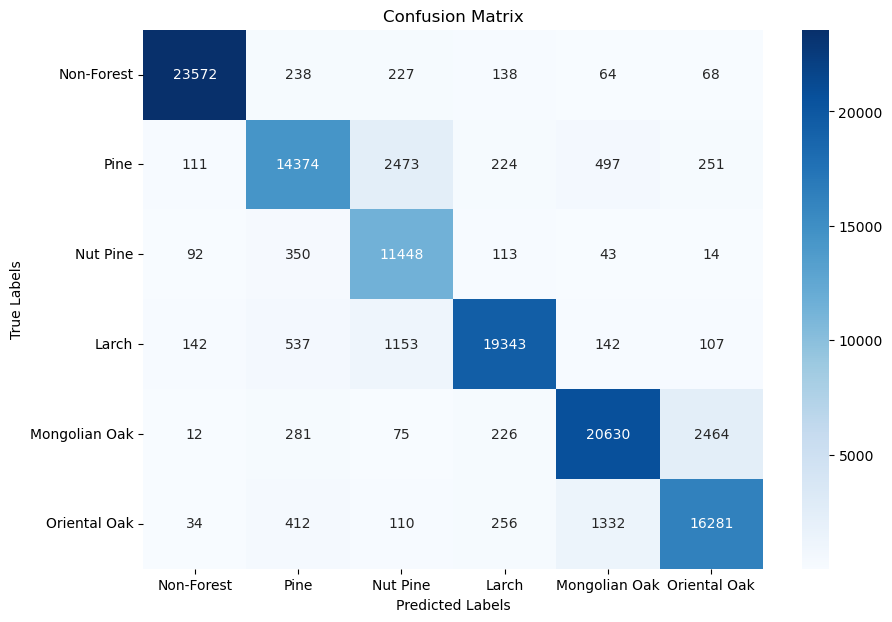

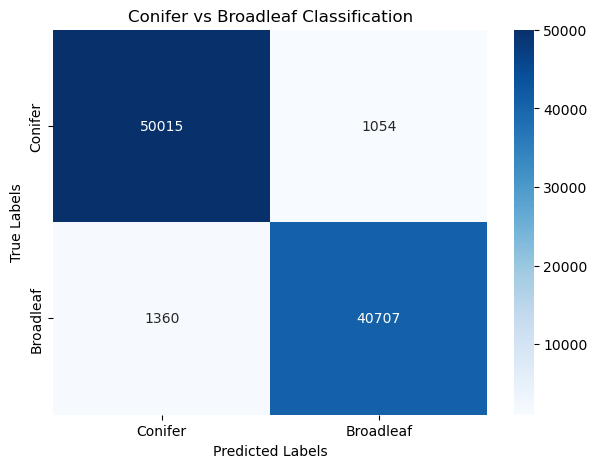

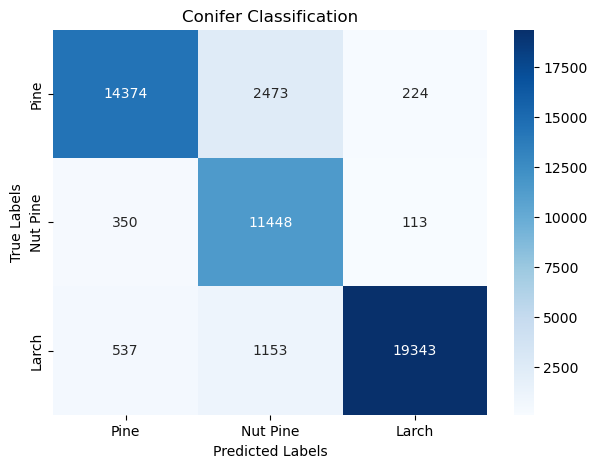

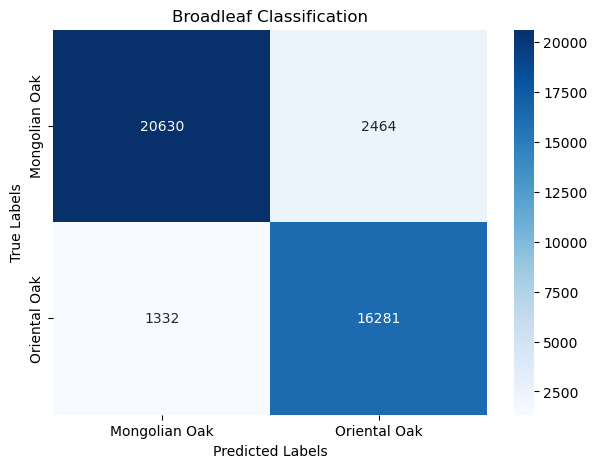


validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:16<00:00, 69.61it/s]


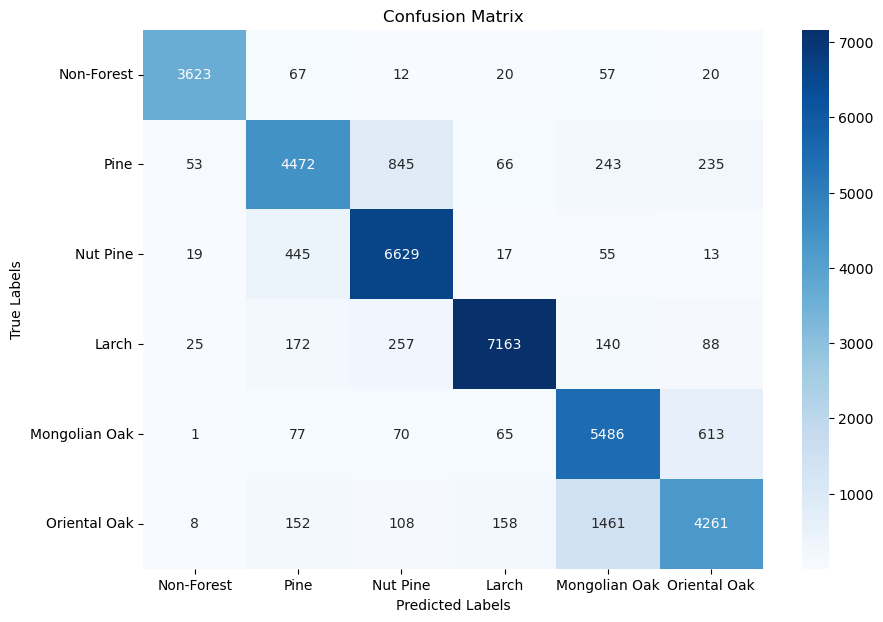

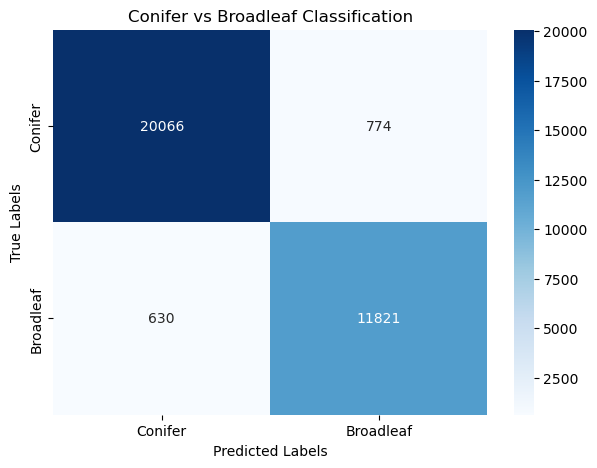

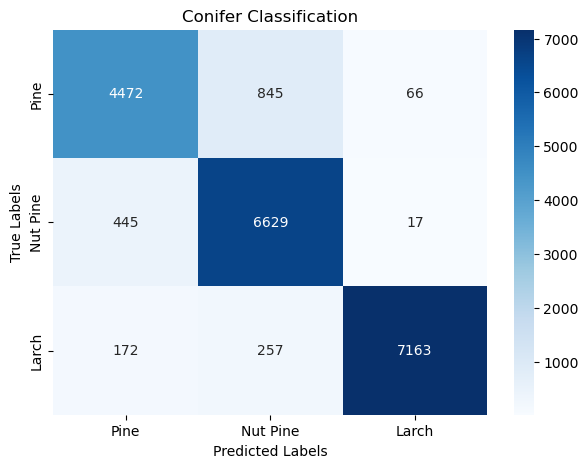

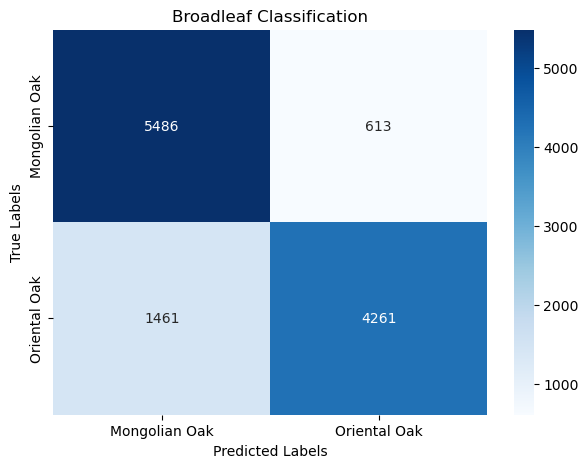

,precision,recall,f1-score,support,Category
Non-Forest,0.971574,0.953672,0.962540,3799.000000,Overall
Pine,0.830455,0.756172,0.791574,5914.000000,Overall
Nut Pine,0.836889,0.923516,0.878071,7178.000000,Overall
Larch,0.956469,0.913066,0.934264,7845.000000,Overall
Mongolian Oak,0.737167,0.869138,0.797732,6312.000000,Overall
Oriental Oak,0.814723,0.693071,0.748989,6148.000000,Overall
accuracy,0.850468,0.850468,0.850468,0.850468,Overall
macro avg,0.857880,0.851439,0.852195,37196.000000,Overall
weighted avg,0.854257,0.850468,0.849829,37196.000000,Overall
Conifer,0.969559,0.962860,0.966198,20840.000000,Conifer vs Broadleaf


In [6]:
stage_repeats = [3, 4, 7, 4]
stage_channels = [14, 28, 56, 84]

model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=8)
model.to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100)
torch.save(best_model_state, "./checkpoints/video_classification/VideoClassifier_9_3_100.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)